In [2]:
# 引入常用库
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf # 分位数回归所需
import scipy.stats as st
import datetime as dt
import itertools # 迭代器工具
import math

#import pysnooper # debug
import pickle
from IPython.core.display import HTML

from jqdata import *
from jqfactor import *
import talib # 技术分析

# 使用ts
import tushare as ts

# 画图
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns
# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['SimHei']

# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('ggplot')

# 忽略报错
import warnings
warnings.filterwarnings("ignore")

In [3]:
# tuhsare自动延迟下载，防止频繁调取数据是报错
import time
import logging
import logging.handlers


class TuShare:
    """tushare服务接口自动重试封装类，能够在接口超时情况下自动等待1秒然后再次发起请求，
    无限次重试下去，直到返回结果或者达到最大重试次数。
    """

    def __init__(self, token, logger=None, max_retry=0):
        """构造函数，token：tushare的token；logger：日志对象，可以不传；
        max_retry：最大重试次数，默认为0意为无限重试，建议用10以上100以内。"""
        self.token = token
        if not logger:
            logger = logging.getLogger('TuShare')
            # CRITICAL > ERROR > WARNING > INFO > DEBUG > NOTSET
            logger.setLevel(logging.DEBUG)
            formatter = logging.Formatter(
                '%(asctime)s %(name)s %(pathname)s:%(lineno)d %(funcName)s %(levelname)s %(message)s'
            )
            handler = logging.StreamHandler()
            handler.setFormatter(formatter)
            handler.setLevel(logging.DEBUG)
            logger.addHandler(handler)
        self.logger = logger
        self.max_retry = max_retry
        ts.set_token(token)
        self.pro = ts.pro_api()

    def __getattr__(self, name):
        def wrapper(*args, **kwargs):
            i = 0
            while True:
                try:
                    if name == 'pro_bar':
                        m = getattr(ts, name, None)
                    else:
                        m = getattr(self.pro, name, None)
                    if m is None:
                        self.logger.error('Attribute %s does not exist.', name)
                        return None
                    else:
                        return m(*args, **kwargs)
                except (Exception):
                    if self.max_retry > 0 and i >= self.max_retry:
                        raise
                    self.logger.exception(
                        'TuShare exec %s failed, args:%s, kwargs:%s, try again.',
                        name, args, kwargs)
                    time.sleep(1)
                i += 1

        return wrapper


# 更改为自己的token,获取的数据
my_ts = TuShare('token',
                  max_retry=10)

# <font color=IndianRed>波动率是刻画市场状态的重要特征</font>

## <font color=IndianRed>波动率的定义与特点</font>

<u>波动率是反映资产价格波动程度，度量**资产收益不确定性和资产风险水平**的常用指标</u>。广义来讲，波动率可以分为实际波动率、历史波动率、隐含波动率和预测波动率等类别。本 文研究的波动率为历史波动率。波动率指标的计算主要基于股票指数的收益率，是过去历 史 n 个交易日收益率的标准差。

采用历史波动率的特点是波动率的变化特征会受到参数 n 的影响。<font color=LightCoral>**n越小，对短期的变化越敏感**</font>，其变化速度就会越快，<font color=LightCoral>**n 越大**</font>，波动率的变化就会越平滑，<font color=LightCoral>**更能反映长期的趋势**</font>，这个特征与移动平均（MA）的特点是一致的。

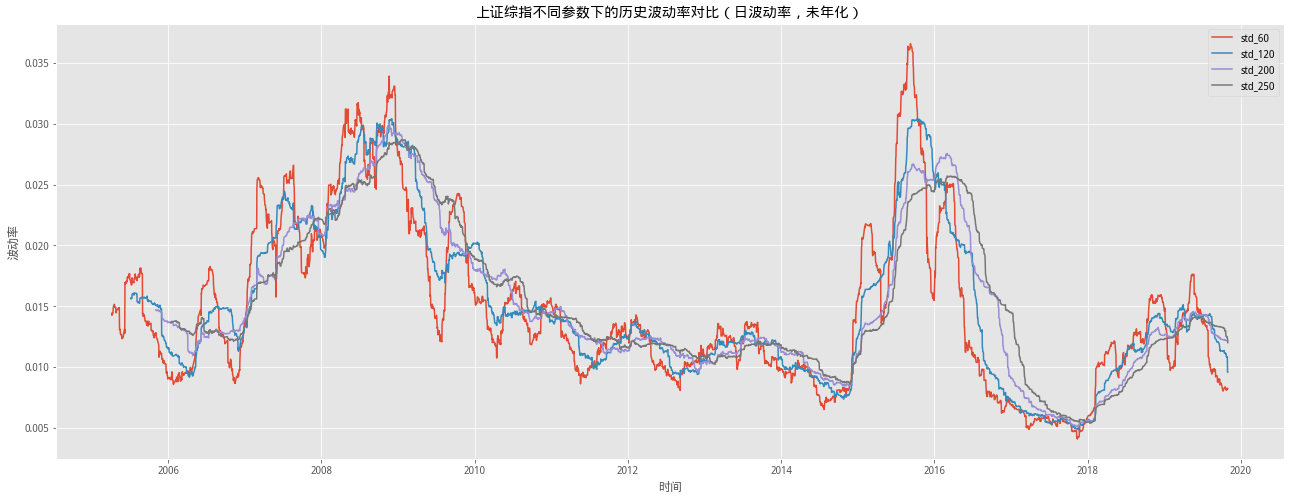

In [4]:
# 图表2 上证综指不同参数下的历史波动率对比（日波动率，未年化）

start = '2000-01-01'
end = '2019-10-31'
# 获取上证收盘数据
close_df = get_price('000001.XSHG', start, end, fields=['close', 'pre_close'])
# 计算收益率
close_df['pct'] = close_df['close']/close_df['pre_close']-1

# 画图
plt.figure(figsize=(22, 8))
# 计算n日波动率  未年化处理
for periods in [60, 120, 200, 250]:

    col = 'std_'+str(periods)
    close_df[col] = close_df['pct'].rolling(periods).std()
    plt.plot(close_df[col], label=col)

plt.legend(loc='best')
plt.xlabel('时间')
plt.ylabel('波动率')
plt.title('上证综指不同参数下的历史波动率对比（日波动率，未年化）')
plt.show()

## <font color=IndianRed>波动率指标历史特征</font>

这里我们重点关注**长期限**的历史波动率，因为我们希望指标能够描述一段时间的市场特征，而且最好是能够持续一段时间、反映市场涨跌结构的特征。从 2000 年以后来看， 市场波动率与市场走势的相关性是存在轮动规律的。2001 年 7 月至 2002 年 9 月，波动率 随着市场下跌逐步上升，2002 年之后波动率开始回落，这时波动率与上证综指的相关性 也开始一路走高。2004 年 5 月之后，随着市场的下跌波动率再次走高，两者的相关性一 路走低，从高度正相关变为高度负相关。2005 年 11 月在市场逐步转暖后波动率也开始回 落。2006 年底，市场进入大牛市，波动率开始走高，在 2007 年底市场转为下跌后波动率 继续走高，一直到 2009 年初市场开始反弹，波动率才开始下降。这次下降期十分漫长， 一共持续了 6 年左右，2014 年底市场重新进入大牛市，波动率再次开始上升。在 2007 年市场大牛市期间，波动率与市场指数的相关性先从负相关变为正相关，再从正相关变为了负相关。2015 年的牛市期间，同样出现了这个现象。

实际上，对于 A股来说，波动率的上升并非单单来源于市场的下跌，经常出现的快速上涨 也会使得波动率整体走高，2007年和2015年就是典型的市场上涨带动波动率上升的例子。 但是市场上涨带来的波动率上升不会因为上涨的停止而停止，上涨之后的下跌将使得波动 率进一步上升。也就是说，在一轮完整的上涨和下跌里面，下跌的波动大概率依然是高于 上涨的情形的。2011 年至 2014 年的震荡市场似乎是一个例外，这是因为我们采用长期波 动率的原因，这段时间的上涨下跌周期较多，长周期波动率并不能较好的捕捉短周期的涨
跌情形。

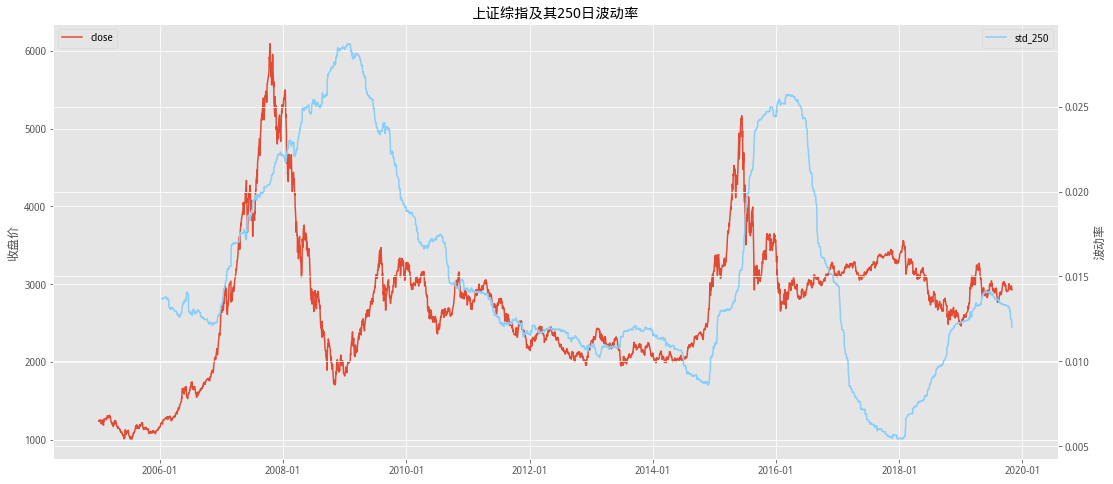

In [5]:
# 图表3 上证综指及其250日波动率

y1 = close_df['close']  # 获取收盘数据
y2 = close_df['std_250']  # 获取250日波动率

fig = plt.figure(figsize=(18, 8))  # 图表大小设置

ax1 = fig.add_subplot(111)

ax1.plot(y1, label='close')
ax1.set_ylabel('收盘价')
plt.legend(loc='upper left')


ax2 = ax1.twinx()  # 设置双Y轴 关键function
ax2.plot(y2, '#87CEFA')
ax2.set_ylabel('波动率')
plt.legend(loc='best')

ax1.set_title("上证综指及其250日波动率")
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))  # x轴显示Y-m
plt.xlabel('时间')
plt.show()

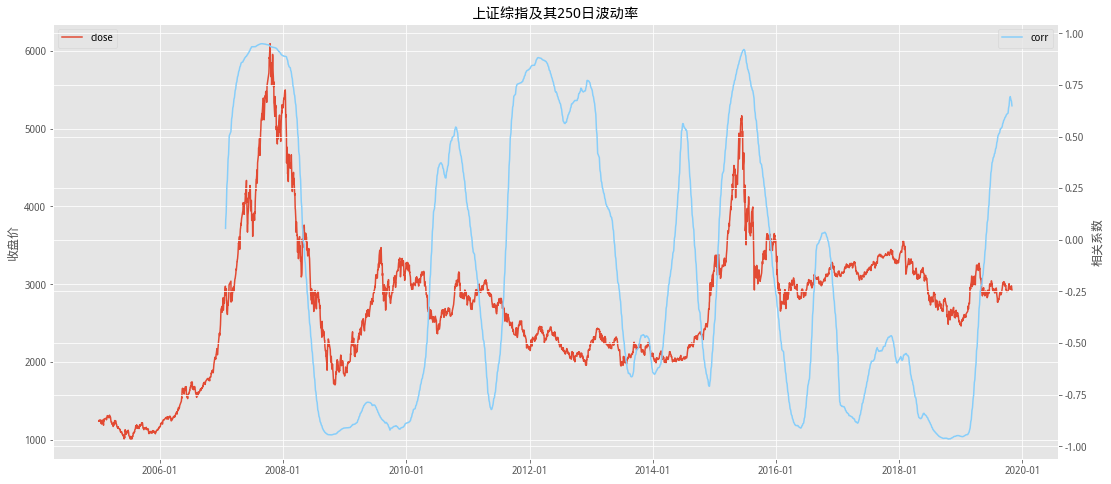

In [6]:
#  图表4:上证综指与波动率的滚动相关系数

y1 = close_df['close'] # 获取收盘数据

# 获取250日波动率与收盘价滚动1年相关系数corr
y2 = close_df['close'].rolling(250).corr(close_df['std_250']) 

fig,ax = plt.subplots(1,1,figsize=(18,8)) # 图表大小设置


ax.plot(y1,label='close') 
ax.set_ylabel('收盘价')
plt.legend(loc='upper left')

ax1 = ax.twinx()  # 设置双Y轴 关键function
ax1.plot(y2,'#87CEFA',label='corr')
ax1.set_ylabel('相关系数')
plt.legend(loc='upper right')

ax1.set_title("上证综指及其250日波动率")
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m')) # x轴显示Y-m
plt.xlabel('时间')
plt.show()

# <font color=IndianRed>换手率与市场走势明显正相关</font>
## <font color=IndianRed>两种换手率的定义与异同</font>

<font color=LightCoral>**换手率**</font>是一定时间内市场中股票转手买卖的频率，是<font color=LightCoral>**反映股票流动性强弱和交易活跃度的指标**</font>之一。成交量和换手率都是反映股票交易规模的指标，但前者是一个绝对数值概念， 随着市场总股本的增加自然增长；后者是相对数值型指标，以百分比形式呈现出来，<font color=LightCoral>**能够更好地在不同时间跨度上进行比较**</font>。股票***每日换手率为当天成交量占流通股本的比例***，这里基于流通股本的算法就会出现两种不同的换手率，

*一种是基于流通总股本计算的换手率，* 

*另一种是基于自由流通股本计算的换手率。*

股票指数的换手率与单只股票的换手率类似， 区别在于分子变成了成分股成交量的加总，分母变成了成分股流通股本的加总。同样根据流通股本选用流通总股本和自由流通股本的不同会出现两种换手率。


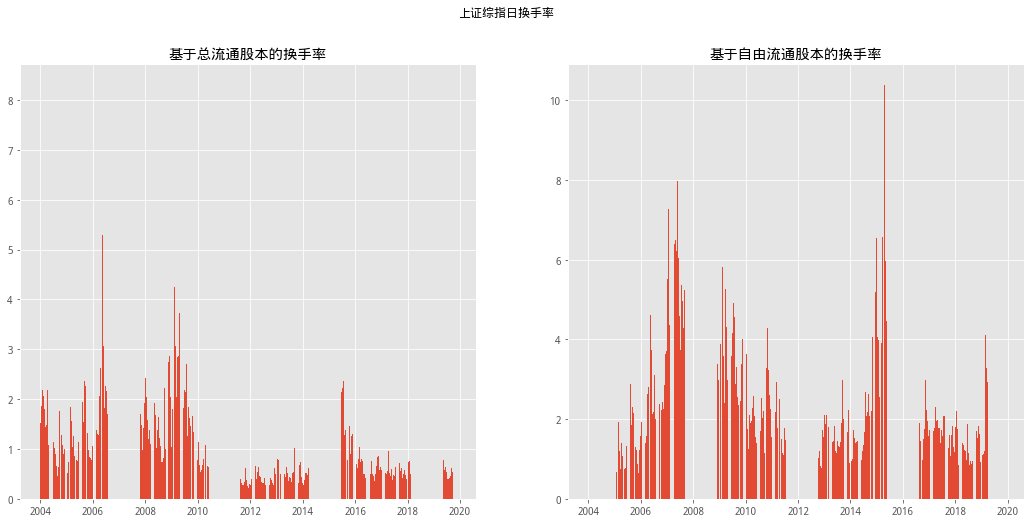

In [7]:
# 图5，6 上证综指日换手率(这里调用了tushare数据，需要tushare 400积分才能调用)

# tushare=>float_share流通股本 （万股），free_share自由流通股本 （万）
# tushare 指数数据从2004年开始提供....有单次查询限制

part_a = my_ts.index_dailybasic(ts_code='000001.SH',
                                start_date=start.replace('-', ''),
                                end_date='20160101',
                                fields='ts_code,trade_date,turnover_rate,turnover_rate_f')

part_b = my_ts.index_dailybasic(ts_code='000001.SH',
                                start_date='20160101',
                                end_date=end.replace('-', ''),
                                fields='ts_code,trade_date,turnover_rate,turnover_rate_f')

index_daily_df = part_a.append(part_b)  # 合并数据
index_daily_df.index = pd.to_datetime(index_daily_df.trade_date)  # 设置索引
index_daily_df.sort_index(inplace=True)  # 排序

# 画图
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('上证综指日换手率')

x = index_daily_df.index
ax[0].bar(x, index_daily_df['turnover_rate'])
ax[0].set_title('基于总流通股本的换手率')

ax[1].bar(x, index_daily_df['turnover_rate_f'])
ax[1].set_title('基于自由流通股本的换手率')

plt.show()

对比两种换手率可以发现，基于自由流通股本的换手率数值整体高于基于总流通股本的换手率，这个容易理解，因为计算换手率的时候两者分子相同，但是基于总流通股本的换手率无疑分母更大。从局部上看，两者的走势其实是一致的，都能够反映市场局部的流动性、 活跃度的变化。但是从整体上来看，基于总流通股本的换手率的平均水平是在下降的，特别是2015年的牛市换手率水平不到2007年牛市换手率的一半。这一点并不能真实的反 映市场情况，我们不认为 2015 年市场的活跃程度会低于 2007 年。相反，采用基于自由流通股本计算的换手率显示的交易活跃度并没有长期下降的趋势，并且 2015 年换手率的 峰值与 2007 年相仿。这说明<font color=LightSeaGreen>**采用总流通股本计算的换手率对市场的交易活跃程度有所低估**</font>，特别是在 2010 年之后非自由流通股本占比越来越高的情况下。因此，从逻辑的顺畅 性和指标前后的一致性上考虑，我们<font color=LightSeaGreen>*倾向于采用***自由流通股本***计算的换手率进行后续研究*</font>。 本文除特殊说明外，之后的换手率都指代的是采用自由流通股本计算的换手率。实际上，在后续划分市场状态和构建牛性指标开发择时策略的研究中，两种换手率的差异很小。

## <font color=IndianRed>换手率指标历史形态</font>

在本研究中，我们<font color=LightCoral>**不关心换手率每日的数值，关心的是换手率整体的趋势**</font>，因此在处理中， 我们**借鉴移动平均的方法**，来考察一段时间换手率趋势性的变化。采用了均线的处理之后， 均线的参数的选取对换手率指标就会产生影响。同波动率类似，均线参数越小，对小波动
的识别性越好，均线参数越大，对长趋势的识别越稳定。

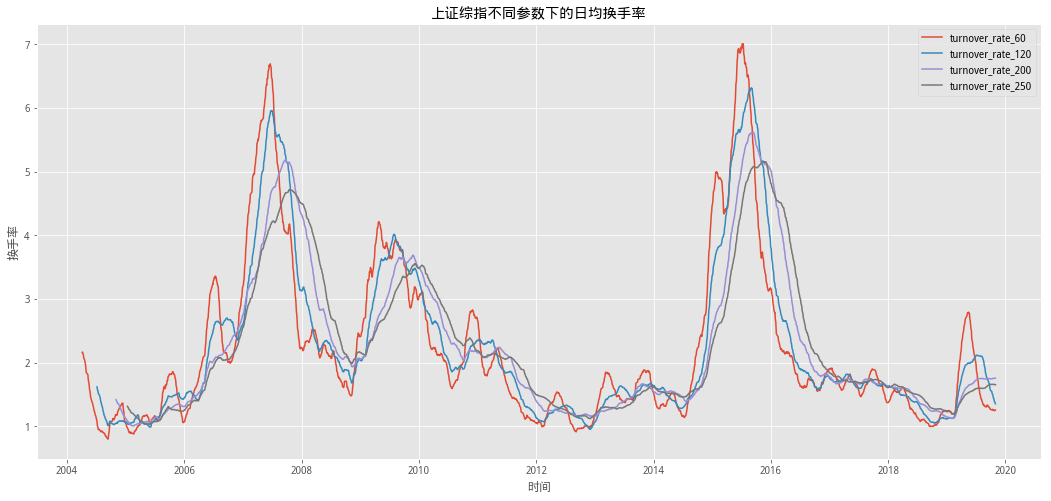

In [8]:
# 图表7  上证综指不同参数下的日均换手率

# 画图
plt.figure(figsize=(18, 8))

for periods in [60, 120, 200, 250]:

    col = 'turnover_rate_'+str(periods)
    index_daily_df[col] = index_daily_df['turnover_rate_f'].rolling(
        periods).mean()
    plt.plot(index_daily_df[col], label=col)

plt.legend(loc='best')
plt.xlabel('时间')
plt.ylabel('换手率')
plt.title('上证综指不同参数下的日均换手率')
plt.show()

换手率与指数走势呈现明显的正相关性，为了与波动率统一，我们依然观察250日均换手率与上证指数的关系。换手率与指数的走势整体上呈现出明显的正相关性，在技术分析中，价量是常被一起提及的指标，换手率本质上属于量的概念，在市场明显的上涨行情中，量 也是明显上升的，这也可以直观的理解为牛市都是需要成交量来推动的。当然，由于我们采用了均线的方法，因此在一些关键拐点处确实会出现滞后的特征。

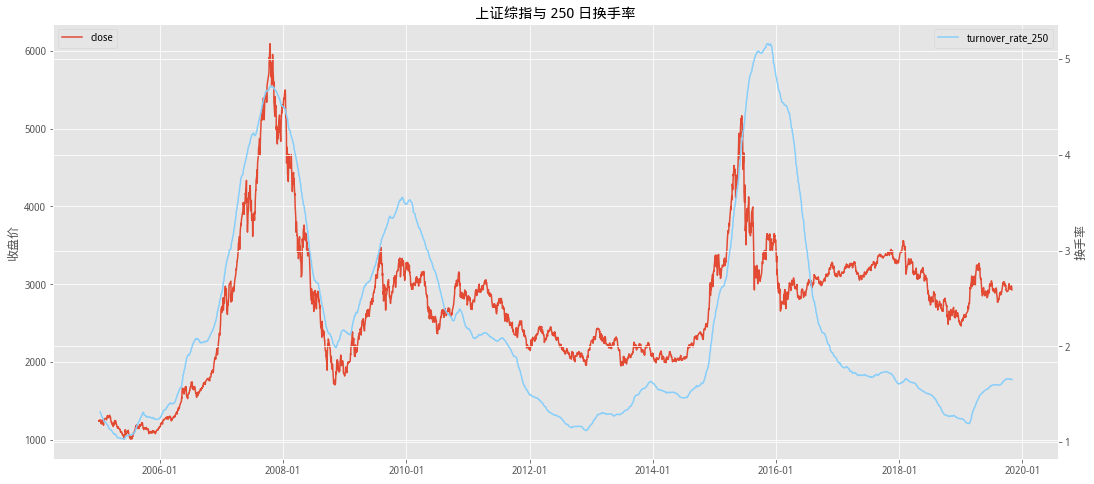

In [9]:
# 图表8 上证综指与 250 日换手率

close_df['turnover_rate_250'] = index_daily_df['turnover_rate_250']
y1 = close_df['close']  # 获取收盘数据
y2 = close_df['turnover_rate_250']  # 获取250日波动率

fig = plt.figure(figsize=(18, 8))  # 图表大小设置

ax1 = fig.add_subplot(111)

ax1.plot(y1, label='close')
ax1.set_ylabel('收盘价')
plt.legend(loc='upper left')


ax2 = ax1.twinx()  # 设置双Y轴 关键function
ax2.plot(y2, '#87CEFA')
ax2.set_ylabel('换手率')
plt.legend(loc='best')

ax1.set_title("上证综指与 250 日换手率")
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))  # x轴显示Y-m
plt.xlabel('时间')
plt.show()

# <font color=IndianRed>波动率与换手率能够较好地对市场状态进行划分</font>
## <font color=IndianRed>上证综指涨跌的历史特征</font>

我们借助于波动率与换手率两个维度来对市场进行观察，类似美林投资时钟，可以将市场分为四种状态：波动率换手率同时上行、波动率换手率同时下行、波动率上行换手率下行、 波动率下行换手率上行。这四种状态对应的市场走势有较强的规律性。在波动率上行、换 手率下行的状态下，市场是典型的熊市特征，市场的下跌一方面会使得波动率上行，另一 方面会使成交量萎缩，造成换手率下行；在波动率和换手率同时上行时，市场是典型的牛 市特征，市场快速上涨使得波动率上行，投资者的交易热情高涨使得换手率上行；波动率 下行、换手率上行时，市场表现也往往比较好，这个阶段经常是牛市的初期或者熊市之后 的反弹；波动率和换手率同时下行，往往发生在震荡市中，这个阶段市场的方向性不好判断，可能震荡下跌也可能震荡上涨。

In [10]:
# 说明
print('这里换手率单位为百分位,我们将波动率*100是单位保持一直，为了使两个参数都在次轴反应对波动率*2\n')

print('波动率:\n', (close_df['std_250']*100*2).describe(), '\n')

print('换手率\n', close_df['turnover_rate_250'].describe())

这里换手率单位为百分位,我们将波动率*100是单位保持一直，为了使两个参数都在次轴反应对波动率*2

波动率:
 count    3354.000000
mean        3.053004
std         1.197174
min         1.086358
25%         2.279291
50%         2.646412
75%         3.941511
max         5.739981
Name: std_250, dtype: float64 

换手率
 count    3597.000000
mean        2.265078
std         1.081355
min         1.031240
25%         1.468440
50%         1.887985
75%         2.822200
max         5.159680
Name: turnover_rate_250, dtype: float64


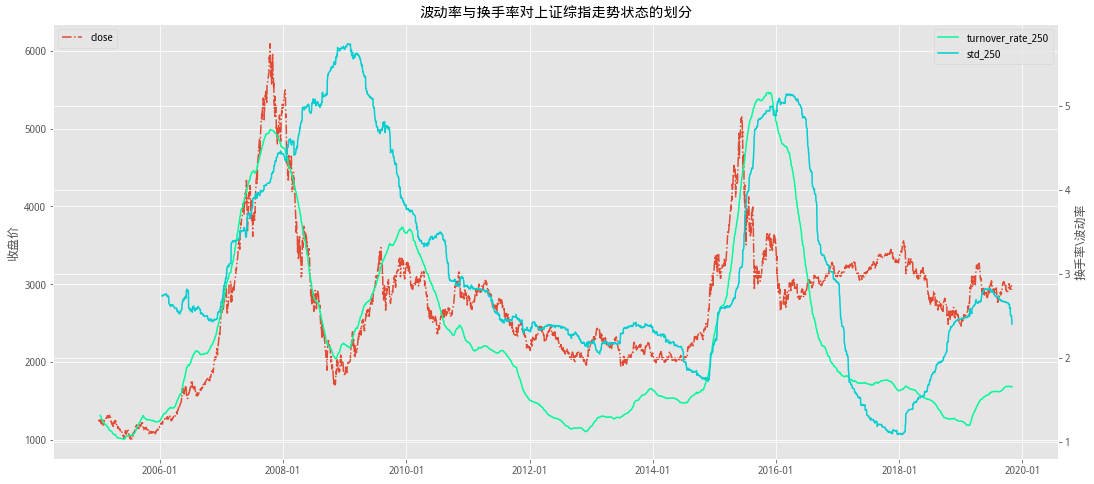

In [11]:
#  图表9 波动率与换手率对上证综指走势状态的划分

y1 = close_df['close']  # 获取收盘数据
y2 = close_df['turnover_rate_250']  # 获取250日波动率
y3 = close_df['std_250']*100*2  # 换手率为%，所以这里要*100

fig = plt.figure(figsize=(18, 8))  # 图表大小设置

ax1 = fig.add_subplot(111)

ax1.plot(y1, linestyle='-.', label='close')
ax1.set_ylabel('收盘价')
plt.legend(loc='upper left')


ax2 = ax1.twinx()  # 设置双Y轴 关键function
ax2.plot(y2, '#00FA9A')
ax2.plot(y3, '#00CED1')
ax2.set_ylabel('换手率\波动率')
plt.legend(loc='best')

ax1.set_title("波动率与换手率对上证综指走势状态的划分")
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))  # x轴显示Y-m
plt.xlabel('时间')
plt.show()

# <font color=IndianRed>波动率换手率构建的牛熊指标与市场负相关性明显</font>

上文我们展示了可以利用波动率与换手率对市场状态进行定位，另外一方面，我们可以把换手率和波动率进行耦合构造**牛熊指标**直接对市场进行观察。牛熊指标的构建方式非常简单，我们将其定义为<font color=LightCoral>**波动率与换手率的比值**</font>。如此构造出来的牛熊指标与指数本身的走势 呈现明显的负相关。以上证综指为例，<font color=LightCoral>两者相关系数为-0.55(研报计算值为-0.67)</font>。当牛熊指标上升时，市场往往处于下跌状态，牛熊指标下降时，市场往往处于上涨状态。

<font color=DarkTurquoise>**PS:研报中在这里没有说用具体什么周期计算的波动率/换手率构建指标 在这里我用的200日来计算**</font>

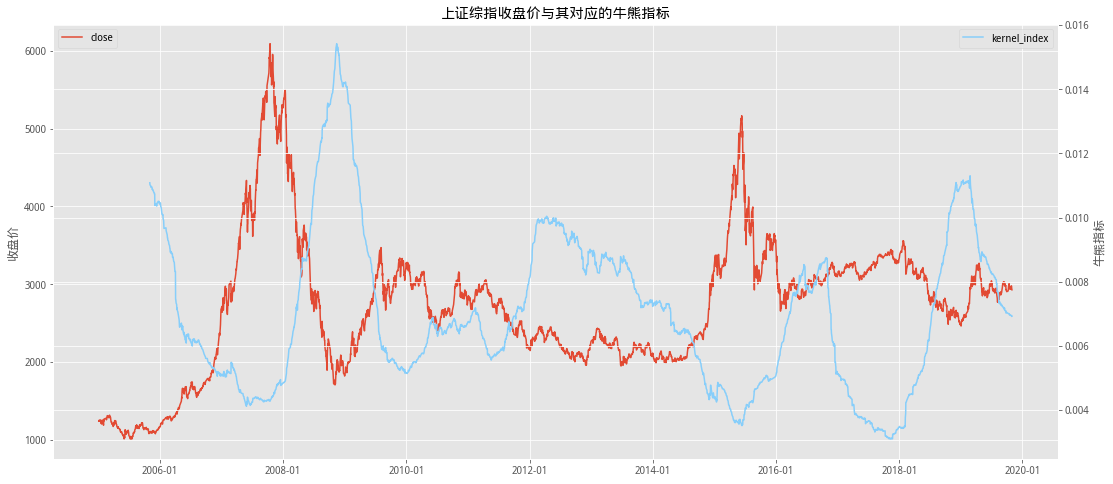

In [12]:
# 图表11

# 计算牛熊指标

close_df['kernel_index'] = close_df['std_200'] / \
    index_daily_df['turnover_rate_200']

y1 = close_df['close']  # 获取收盘数据
y2 = close_df['kernel_index']  # 获取250日波动率

fig = plt.figure(figsize=(18, 8))  # 图表大小设置

ax1 = fig.add_subplot(111)

ax1.plot(y1, label='close')
ax1.set_ylabel('收盘价')
plt.legend(loc='upper left')


ax2 = ax1.twinx()  # 设置双Y轴 关键function
ax2.plot(y2, '#87CEFA')
ax2.set_ylabel('牛熊指标')
plt.legend(loc='best')

ax1.set_title("上证综指收盘价与其对应的牛熊指标")
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))  # x轴显示Y-m
plt.xlabel('时间')
plt.show()

In [13]:
# 牛熊指标与收盘数据的相关系数
corr = close_df[['kernel_index']].corrwith(close_df['close']).values[0]
print('牛熊指标与收盘数据的相关系数:%.2f' % corr)

牛熊指标与收盘数据的相关系数:-0.55


前文中我们利用波动率和换手率将市场状态划分成了四类，其中熊市特征（波动率上行、 换手率下行）在牛熊指标上表现为上升，上升市特征（波动率下行、换手率上行）在牛熊 指标上表现为下降，另外两种特征理论上会使牛熊指标可能上升也可能下降，然后实际中， 牛市特征（波动率上升、换手率上升）在牛熊指标中表现为上升。也就是说，牛市的波动 率上行都是换手率上升所带来的结果，市场的波动放大是交易热情高涨所形成的。震荡市 特征（波动率下行、换手率下行）在牛熊指标上的表现则不尽相同，部分出现上涨部分出 现下跌，此时牛熊指标刚好弥补了震荡市无法判断市场方向的问题。当波动率和换手率都 出现下行时，就需要比较两者的下行速度，若波动率的下行速度大于换手率的下行速度， 说明市场趋于稳定的速度要大于交易热情衰退的速度，这时候牛熊指标下行，市场表现为 上涨，典型如 2017 年的上涨。当波动率的下行速度小于换手率的下行速度，说明市场交 易热情衰减的速度更快，牛熊指标表现为上升，市场发生下跌，典型如 2011 年、2012 年 的震荡下跌。因此牛熊指标很好的弥补了单一使用波动率、换手率对震荡市涨跌方向不好 判断的情况，能够对市场择时起到关键的作用。
在构建牛熊指标时，我们选取的参数都相对较长，因此得到的牛熊指标对中长期趋势的识 别效果较好。同时牛熊指标的平稳性较好，不会因为市场短期的变化就随之发生改变，不 管是主动投资者还是运用量化方法的投资者，都可以借助于牛熊指标对市场进行择时判断。 因为<font color=MediumTurquoise>**牛熊指标对中长期趋势的把握较好，指标更适合中长线资金，特别是做资产配置的投资者**</font>。

# <font color=IndianRed>信号研究及简单回测函数</font>

In [14]:
# 构建分析函数


'''
jqdata计算 指数数据貌似没有 换手率(基于自由流通股本),换手率(基于总流通股本)
自己算自由流通股本太麻烦 因为研报说两个差异不大 所以就构建 换手率(基于总流通股本)

按天计算速度肯定很慢,所以在分析时我还是用ts数据,如果实在没有ts权限可以使用这个,
计算结果跟ts的turnover_rate有点差异
'''


def Cal_index_turnover(indexId, start, end):
    '''
    indexId 为指标名称
    ----------
    return Series
    '''
    tradeList = get_trade_days(start, end)

    temp = {}  # 储存中间数据
    for trade_date in tradeList:

        security = get_index_stocks(indexId, date=trade_date)  # 获取成分股

        # 查询总流通股本
        q_circulating_cap = query(valuation.code,
                                  valuation.circulating_cap).filter(valuation.code.in_(security))

        circulating_cap = get_fundamentals(q_circulating_cap, date=trade_date)

        # 获取成交量,注释部分计算结果更贴近ts数据但很慢,不知道为什么
        volume = get_price(indexId, end_date=trade_date,
                           count=1, fields='volume')
        # volume=get_price(security, end_date=trade_date,count=1, fields='volume,paused').to_frame()

        # 总流通股本换手率
        turnover = volume['volume'].sum(
        )/circulating_cap['circulating_cap'].sum()
        # turnover=volume.query('paused==0')['volume'].sum()/circulating_cap['circulating_cap'].sum()

        temp[trade_date] = turnover
        print('success', trade_date)

    ser = pd.Series(temp)
    ser.name = 'turnover_rate'
    return ser


# -----------------------------------------------------------------------
#               构建信号生成及分析模块
# -----------------------------------------------------------------------
'''
模块使用ts调用数据
ts_code xxxxx.SH 上海，xxxxxx.SZ 深圳

e.g:上证代码：000001.SH,hs300:000300.SH,中证500:000905.SH代码格式以此类推

日期：yyyymmmdd
'''


class VT_Factor(object):

    def __init__(self, indexId, start, end, periods, forward_n=[5, 10, 15, 20]):

        self.indexId = indexId  # 指数名称
        self.start = start  # 起始日期
        self.end = end  # 结束日期
        self.periods = periods  # 为指标计算周期
        self.forward_n = forward_n  # 需要获取未来n日收益的list
    # ---------------------------------------------------------------------
    #                   数据获取 ts
    # ---------------------------------------------------------------------

    '''
    数据最早为2004年1月开始
    ts单一指数最多提取12年的数据,多指数最多3000条
    '''
    @property
    def get_data(self):
        '''
        return df index-date columns-close|pct_chg|turnover_rate_f
        '''
        indexId = self.indexId
        start = self.start
        end = self.end

        # 获取自由流通 换手率
        '''
        turnover = my_ts.index_dailybasic(ts_code=indexId,
                                          start_date=start,
                                          end_date=end,
                                          fields='trade_date,turnover_rate_f').set_index('trade_date')                            
        '''

        turnover = self.get_turnover

        # 获取收盘价数据
        close = my_ts.index_daily(ts_code=indexId,
                                  start_date=start,
                                  end_date=end,
                                  fields='trade_date,close,pct_chg').set_index('trade_date')

        df = close.join(turnover)
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        return df

    # 获取ts index_dailybasic 绕过调取限制
    @property
    def get_turnover(self):

        indexId = self.indexId
        start = self.start
        end = self.end

        total = my_ts.trade_cal(exchange='SSE', start_date=start, end_date=end)
        trade_list = total.query('is_open==1').cal_date.values.tolist()
        trade_size = len(trade_list)  # 获取总长度
        

        if trade_size <= 3000:

            df = my_ts.index_dailybasic(ts_code=indexId,
                                        start_date=start,
                                        end_date=end,
                                        fields='trade_date,turnover_rate_f').set_index('trade_date')

            return df

        else:

            count = int(math.ceil(trade_size/3000.0))  # 需要循环的次数
            
            temp = []
            temp.append(min(trade_list))

            for i in range(1, count+1):
                
                idx = trade_list[min(i*3000,trade_size-1)]
                temp.append(idx)

            temp_df = []
            for x in zip(temp[:-1], temp[1:]):
                df = my_ts.index_dailybasic(ts_code=indexId,
                                            start_date=x[0],
                                            end_date=x[1],
                                            fields='trade_date,turnover_rate_f').set_index('trade_date')
                temp_df.append(df)

            return pd.concat(temp_df)

    # ---------------------------------------------------------------------
    #                   牛熊指标构建
    # ---------------------------------------------------------------------

    # 计算牛熊指标
    def _Calc_func(self, x_df):
        '''
        输入为df index-date column-turnovet_rate_f|close|pct_chg
        ============
        return series/pd index-date valus-牛熊指标 kernel_n
        '''
        df = x_df.copy()
        periods = self.periods  # 获取计算周期
        if not isinstance(periods, list):
            periods = [periods]

        # 计算牛熊指标
        series_temp = []
        for n in periods:
            turnover_ma = df['turnover_rate_f'].rolling(n).mean()
            std = df['pct_chg'].rolling(n).std(ddof=0)
            kernel_factor = std/turnover_ma
            kernel_factor.name = 'kernel_'+str(n)
            series_temp.append(kernel_factor)

        if len(series_temp) == 1:

            return kernel_factor

        else:

            return pd.concat(series_temp, axis=1)

    # 获取信号
    @property
    def get_singal(self):
        '''
        return df index-date columns-close|pct_chg|kernel_n|turnover_rate_f

        '''
        data = self.get_data  # 获取数据
        singal_df = self._Calc_func(data)  # 计算数据
        data = data.join(singal_df)

        return data

    # ---------------------------------------------------------------------
    #                   信号指标未来收益相关分析函数
    # ---------------------------------------------------------------------

    # 计算未来收益
    def _Cal_forward_ret(self, x_df, singal_periods):
        '''
        df为信号数据 index-date columns-close|pct_chg|kernel_n
        singal_periods int
        forwart_n 需要获取未来n日收益的list
        ===========
        return df

        index-date colums kernel_n|未来x日收益|pct_chg
        '''

        forward_n = self.forward_n  # 获取N日未来收益

        df = x_df[['close', 'pct_chg', 'kernel_'+str(singal_periods)]].copy()

        # 获取指数数据
        df['未来1日收益率'] = df['pct_chg'].shift(-1)  # next_ret

        for n in forward_n:
            col = '未来{}日收益率'.format(n)
            df[col] = df['close'].pct_change(n).shift(-n)  # next_ret_n

        df = df.drop('close', axis=1)  # 丢弃不需要的列

        return df

    # 信号分段对应的收益率

    def forward_distribution_plot(self, singal_periods, bins=50):
        '''
        bins 分组
        =============
        return 图表
        '''

        data = self.get_singal  # 获取信号数据
        forward_df = self._Cal_forward_ret(data, singal_periods)  # 获取未来收益
        slice_arr = pd.cut(
            forward_df['kernel_'+str(singal_periods)], bins=bins)  # 信号分为组

        forward_df['barrel'] = slice_arr

        group_ret = [x for x in forward_df.columns if x.find(
            '日收益率') != -1]  # 获取未来收益列

        list_size = len(group_ret)  # 子图个数

        # 画图
        f, axarr = plt.subplots(list_size, figsize=(18, 15))  # sharex=True 画子图
        f.suptitle(' 信号对应收益分布')  # 设置总标题

        # 设置子图间隔等
        f.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.65,
                          wspace=0.35)

        for i in range(list_size):

            ret_series = forward_df.groupby('barrel')[group_ret[i]].mean()
            x = ret_series.index.astype('str').tolist()

            axarr[i].bar(x, ret_series.values)  # 画子图
            axarr[i].set_title(group_ret[i])  # 设置子图名称
            axarr[i].set_xticklabels(x, rotation=90)  # 设置子图刻度标签及标签旋转

        plt.show()

    # 画分信号位数与收益的相关系数
    def QuantReg_plot(self, forward_ret_name, singal_periods):
        '''
        forward_ret_name 需要比较的未来收益的名称
        '''
        data = self.get_singal  # 获取信号数据

        forward_df = self._Cal_forward_ret(data, singal_periods)  # 获取未来收益

        x = forward_ret_name  # 设置未来收益名称
        traget = 'kernel_'+str(singal_periods)+'~'+x

        mod = smf.quantreg(traget, forward_df)
        res = mod.fit(q=.5)
        print(res.summary())

        quantiles = np.arange(.05, .96, .1)

        def fit_model(q):
            res = mod.fit(q=q)
            # conf_int为置信区间
            return [q, res.params['Intercept'], res.params[x]] + \
                res.conf_int().loc[x].tolist()

        models = [fit_model(q_i) for q_i in quantiles]
        models_df = pd.DataFrame(
            models, columns=['quantiles', 'Intercept', x, 'lb', 'ub'])

        n = models_df.shape[0]

        plt.figure(figsize=(18, 8))
        p1 = plt.plot(models_df['quantiles'], models_df[x],
                      color='red', label='Quantile Reg.')
        p2 = plt.plot(models_df['quantiles'], models_df['ub'],
                      linestyle='dotted', color='black')
        p3 = plt.plot(models_df['quantiles'], models_df['lb'],
                      linestyle='dotted', color='black')

        plt.ylabel(r'$\beta_{RETURNS}$')
        plt.xlabel('信号分位数')
        plt.legend()
        plt.show()

# ---------------------------------------------------------------------
#                   回测
# ---------------------------------------------------------------------


class BackTesting(object):
    '''
    传入的df 必须有信号名称 必须有pct_chg
    '''

    def __init__(self, x_df, singal_name, method, hold=None, **threshold):

        self.df = x_df.copy()
        self.threshold = threshold
        self.hold = hold
        self.singal_name = singal_name  # 需要回测的col_name
        self.method = method

    # 选择回测策略
    @property
    def Choose_Strategy(self):

        threshold = self.threshold
        hold = self.hold
        method = self.method

        if method:
            if method == 'MA':
                return (4, '金叉死叉策略')
            elif method == 'BBANDS':
                return (5, '布林通道策略')
            else:
                return 0
        else:
            # 当阈值不为元组时说明只有单值，单值默认为开仓信号
            k = list(threshold.keys())[0]  # key
            threshold_value = threshold[k]  # 如果有两个值则(a,b),单值为a
            # 单值+有持仓
            # 1.出现开仓信号时开仓,持有N天后平仓
            if not isinstance(threshold_value, tuple) and hold != None:

                return (1, '出现开仓信号时开仓,持有N天后平仓')

            # 单值+无持仓
            # 2.大于开仓信号开仓,直到小于开仓信号平仓
            elif not isinstance(threshold_value, tuple) and hold == None:

                return (2, '大于开仓信号开仓，直到小于开仓信号平仓')

            # 双值+无持仓
            # 3. a<信号<b 时开仓,反之保持空仓(有仓位则平仓)
            elif isinstance(threshold_value, tuple) and hold == None:

                return (3, 'a<信号<b 时开仓,反之保持空仓(有仓位则平仓)')

            else:

                return 0  # 不能出现这种情况

    # 1.出现开仓信号时开仓,持有N天后平仓

    def Strategy_a(self, x_df):
        '''
        开仓标记点 list
        '''
        threshold = self.threshold
        hold = self.hold
        count = hold
        data = x_df.copy()  # 计算信号

        k = list(threshold.keys())[0]  # key
        threshold_value = threshold[k]
        singal_arr = data['SINGAL'].values

        trade_mark = np.where(singal_arr > threshold_value, 1, 0)  # 标记交易点

        # 读取信号点
        position = []
        for x in trade_mark:
            if x == 1:
                position.append(1)
                count = 1
            else:
                if count < hold:
                    count += 1
                    position.append(1)
                else:
                    position.append(0)

        return position  # 开仓标记点

    # 2.大于开仓信号开仓,直到小于开仓信号平仓

    def Strategy_b(self, x_df):

        threshold = self.threshold
        hold = self.hold

        data = x_df.copy()  # 计算信号

        k = list(threshold.keys())[0]  # key
        threshold_value = threshold[k]
        singal_arr = data['SINGAL'].values

        trade_mark = np.where(singal_arr > threshold_value, 1, 0)  # 标记交易点

        return list(trade_mark)

    # 3. a<信号<b 时开仓,反之保持空仓(有仓位则平仓)

    def Strategy_c(self, x_df):

        threshold = self.threshold
        hold = self.hold

        data = x_df.copy()  # 计算信号

        k = list(threshold.keys())[0]  # key
        threshold_value = threshold[k]

        open_singal = threshold_value[0]  # a
        close_singal = threshold_value[1]  # b

        singal_arr = data['SINGAL'].values

        # a<信号<b
        trade_mark = np.select([singal_arr < open_singal,
                                np.logical_and(
                                    singal_arr >= open_singal, singal_arr <= close_singal),
                                singal_arr > close_singal], [0, 1, 0])

        return list(trade_mark)

    # 4. 均线策略
    def Strategy_MA(self, x_df, inverts=False):
        '''
        inverts：True 正常趋势 False 方向趋势
        ======
        returns list
        '''
        data = x_df.copy()
        singal_arr = self._Cal_MA(data)  # 获取首次出现金叉死叉的标记点 1为金叉，-1为死叉

        trade_mark = []
        # 正常趋势
        if inverts:
            for i in singal_arr:
                if i == 1:
                    trade_mark.append(1)
                else:
                    if len(trade_mark) > 0 and trade_mark[-1] == 1 and i != -1:
                        trade_mark.append(1)
                    else:
                        trade_mark.append(0)

        else:
            # 反趋势
            for i in singal_arr:
                if i == -1:
                    trade_mark.append(1)
                else:
                    if len(trade_mark) > 0 and trade_mark[-1] == 1 and i != 1:
                        trade_mark.append(1)
                    else:
                        trade_mark.append(0)

        return trade_mark  # list

    # 5.布林通道策略

    def Strategy_BBANDS(self, x_df, inverts=False):
        '''
        inverts：True 正常趋势 False 方向趋势
        ======
        returns list
        '''
        data = x_df.copy()
        singal_arr = self._Cal_BBANDS(data)  # 获取首次出现金叉死叉的标记点 1为金叉，-1为死叉

        trade_mark = []
        # 正常趋势
        if inverts:
            for i in singal_arr:
                if i == 1:
                    trade_mark.append(1)
                else:
                    if len(trade_mark) > 0 and trade_mark[-1] == 1 and i != -1:
                        trade_mark.append(1)
                    else:
                        trade_mark.append(0)

        else:
            # 反趋势
            for i in singal_arr:
                if i == -1:
                    trade_mark.append(1)
                else:
                    if len(trade_mark) > 0 and trade_mark[-1] == 1 and i != 1:
                        trade_mark.append(1)
                    else:
                        trade_mark.append(0)

        return trade_mark  # list

    # -------------------------------------------------------------------------------------
    #                             计算金叉死叉和布林通道的突破
    # ------------------------------------------------------------------------------------

    '''
    Cal_MA 计算均线的金叉死叉 金叉为1，死叉为-1
    Cal_BBANDS 计算突破上下轨 突破上轨1，突破下轨-1
    标记的都是*首次*出现点

    '''
    # 4-1.计算20日均线与60日均线的金叉，死叉

    def _Cal_MA(self, x_df):

        df = x_df.copy()

        df['MA_20'] = df['SINGAL'].rolling(20).mean()
        df['MA_60'] = df['SINGAL'].rolling(60).mean()
        df['diff'] = df['MA_20']-df['MA_60']  # 为负数表示ma20<ma60
        df['pre_diff'] = df['diff'].shift(1)  # 昨日diff

        # 金叉/死叉 金叉1 死叉-1 else 0a
        # if x['pre_diff']<0 and x['diff']>=0  金叉
        # if x['pre_diff']>0 and x['diff']<=0 死叉
        df['mark'] = df[['pre_diff', 'diff']].apply(lambda x: 1 if x['pre_diff'] < 0 and x['diff'] >= 0
                                                    else (-1 if x['pre_diff'] > 0 and x['diff'] <= 0 else 0), axis=1)

        return df['mark'].values.tolist()  # list

    # 5-1.布林通道策略
    def _Cal_BBANDS(self, x_df):

        df = x_df.copy()

        df['MA_20'] = df['SINGAL'].rolling(20).mean()
        std_arr = df['SINGAL'].rolling(20).std()
        df['UP'] = df['MA_20']+2*std_arr
        df['LOW'] = df['MA_20']-2*std_arr

        df['updiff'] = df['SINGAL']-df['UP']
        df['lowdiff'] = df['SINGAL']-df['LOW']

        df['pre_updiff'] = df['updiff'].shift(1)
        df['pre_lowdiff'] = df['lowdiff'].shift(1)

        def mark_func(x):
            return 1 if x['pre_updiff'] < 0 and x['updiff'] >= 0 else (-1 if x['pre_lowdiff'] > 0 and x['lowdiff'] <= 0 else 0)

        df['mark'] = df[['pre_updiff', 'updiff', 'pre_lowdiff', 'lowdiff']].apply(
            mark_func, axis=1)

        return df['mark'].values.tolist()

    # ----------------------------------------------------------------------

    # 回测
    '''
    1.出现开仓信号时开仓,持有N天后平仓；
    2.大于开仓信号开仓,直到小于开仓信号平仓；
    3. a<信号<b 时开仓,反之保持空仓(有仓位则平仓)；
    '''
    @property
    def back_testing(self):
        '''
        为多组信号打上标记
        return df x_trade_mark为标记点
        '''

        data = self.df  # 传入的df
        singal_name = self.singal_name

        strategy_dic = {1: self.Strategy_a,
                        2: self.Strategy_b, 3: self.Strategy_c,
                        4: self.Strategy_MA, 5: self.Strategy_BBANDS, 0: '参数不对'}

        if not isinstance(singal_name, list):
            singal_name = [singal_name]

        inverts = False  # 默认为牛熊指标
        for s in singal_name:

            # 将目标信号改为SINGAL
            data = data.rename(columns={s: 'SINGAL'})

            # 获取标记点
            strategy_x = self.Choose_Strategy

            if strategy_x[0] < 4:

                # print(strategy_x[1])  # 输出策略逻辑
                trade_mark = strategy_dic[strategy_x[0]](data)
                data[s+'_MARK'] = trade_mark
                # 名字改回
                data.rename(columns={'SINGAL': s}, inplace=True)

            elif strategy_x[0] >= 4:

                if s == 'close':
                    inverts = True

                trade_mark = strategy_dic[strategy_x[0]](data, inverts)
                data[s+'_MARK'] = trade_mark
                # 名字改回
                data.rename(columns={'SINGAL': s}, inplace=True)
            else:
                print(strategy_x[1])

        return data

    # 画净值图
    @property
    def plot_net_value(self):

        back_df = self.back_testing  # 获取回测数据
        back_df['pct_chg'] = back_df['pct_chg']/100
        back_df['NEXT_RET'] = back_df['pct_chg'].shift(-1)

        # 寻找标记列
        mark_list = [x for x in back_df.columns if x.split('_')[-1] == 'MARK']

        fig = plt.figure(figsize=(20, 10))
        ax1 = fig.add_subplot(1, 1, 1)

        # 策略
        for n in mark_list:
            RET = back_df['NEXT_RET']*back_df[n]
            CUM = (1+RET).cumprod()
            ax1.plot(CUM, label=n)

        # 基准净值
        benchmark = (1+back_df['pct_chg']).cumprod()

        ax1.plot(benchmark, label='benchmark')

        ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
        plt.legend(loc='best')
        plt.xlabel('时间')
        plt.ylabel('净值')
        plt.title('策略净值曲线')
        plt.show()

    # 回测报告
    @property
    def summary(self):

        back_df = self.back_testing

        index_name = '年化收益率,累计收益率,夏普比率,最大回撤,持仓总天数,交易次数,平均持仓天数,获利天数, \
        亏损天数,胜率(按天),平均盈利率(按天),平均亏损率(按天),平均盈亏比(按天),盈利次数,亏损次数, \
        单次最大盈利,单次最大亏损,胜率(按此),平均盈利率(按次),平均亏损率(按次),平均盈亏比(按次)'.split(
            ',')

        # 寻找标列
        mark_list = [x for x in back_df.columns if x.split('_')[-1] == 'MARK']

        temp = []
        mark_size = len(mark_list)  # 列数

        if mark_size > 1:

            for m in mark_list:

                df = pd.DataFrame(self.risk_indicator(
                    back_df, m), index=index_name)
                temp.append(df)

            return pd.concat(temp, axis=1)

        else:

            return pd.DataFrame(risk_indicator(back_df, m), index=index_name)

    # 计算风险指标

    def risk_indicator(self, x_df, mark_col):
        '''
        传入经back_testing

        '''
        df = x_df.copy()

        summary_dic = {}

        # 格式化数据
        def format_x(x):
            return '{:.2%}'.format(x)

        # 获取回测数据
        df['pct_chg'] = df['pct_chg']/100
        df['NEXT_RET'] = df['pct_chg'].shift(-1)

        NOT_NAN_RET = df['NEXT_RET'].dropna()*df[mark_col]
        RET = df['NEXT_RET']*df[mark_col]

        CUM_RET = (1+RET).cumprod()  # series

        # 计算年化收益率
        annual_ret = CUM_RET.dropna()[-1]**(250/len(NOT_NAN_RET)) - 1

        # 计算累计收益率
        cum_ret_rate = CUM_RET.dropna()[-1] - 1

        # 最大回撤
        max_nv = np.maximum.accumulate(np.nan_to_num(CUM_RET))
        mdd = -np.min(CUM_RET / max_nv - 1)

        # 夏普
        sharpe_ratio = np.mean(NOT_NAN_RET) / \
            np.nanstd(NOT_NAN_RET, ddof=1)*np.sqrt(250)

        # 盈利次数
        temp_df = df.copy()

        diff = temp_df[mark_col] != temp_df[mark_col].shift(1)
        temp_df[mark_col+'_diff'] = diff.cumsum()
        cond = temp_df[mark_col] == 1
        # 每次开仓的收益率情况
        temp_df = temp_df[cond].groupby(mark_col+'_diff')['NEXT_RET'].sum()

        # 标记买入卖出时点
        mark = df[mark_col]
        pre_mark = np.nan_to_num(df[mark_col].shift(-1))
        # 买入时点
        trade = (mark == 1) & (pre_mark < mark)

        # 交易次数
        trade_count = len(temp_df)

        # 持仓总天数
        total = np.sum(mark)

        # 平均持仓天数
        mean_hold = total/trade_count
        # 获利天数
        win = np.sum(np.where(RET > 0, 1, 0))
        # 亏损天数
        lose = np.sum(np.where(RET < 0, 1, 0))
        # 胜率
        win_ratio = win/total
        # 平均盈利率（天）
        mean_win_ratio = np.sum(np.where(RET > 0, RET, 0))/win
        # 平均亏损率（天）
        mean_lose_ratio = np.sum(np.where(RET < 0, RET, 0))/lose
        # 盈亏比(天)
        win_lose = win/lose

        # 盈利次数
        win_count = np.sum(np.where(temp_df > 0, 1, 0))
        # 亏损次数
        lose_count = np.sum(np.where(temp_df < 0, 1, 0))
        # 单次最大盈利
        max_win = np.max(temp_df)
        # 单次最大亏损
        max_lose = np.min(temp_df)
        # 胜率
        win_rat = win_count/len(temp_df)
        # 平均盈利率（次）
        mean_win = np.sum(np.where(temp_df > 0, temp_df, 0))/len(temp_df)
        # 平均亏损率（天）
        mean_lose = np.sum(np.where(temp_df < 0, temp_df, 0))/len(temp_df)
        # 盈亏比(次)
        mean_wine_lose = win_count/lose_count

        summary_dic[mark_col] = [format_x(annual_ret), format_x(cum_ret_rate), sharpe_ratio, format_x(
            mdd), total, trade_count, mean_hold, win, lose, format_x(win_ratio), format_x(mean_win_ratio),
            format_x(mean_lose_ratio), win_lose, win_count, lose_count, format_x(
                max_win), format_x(max_lose),
            format_x(win_rat), format_x(mean_win), format_x(mean_lose), mean_wine_lose]

        return summary_dic

# ---------------------------------------------------------------------
#                   统计指标及图标相关函数
# ---------------------------------------------------------------------

# 计算统计指标


def Statistical_indicator(x_df, col, pre=True):
    '''
    x_df:DataFrame
    col:需要分析的列
    pre:True为打印数据，False 返回指标字典
    ==============
    print OR dic
    '''

    data = x_df[col].copy()  # 导入数据
    data = data.dropna()  # 舍去NA值

    avgRet = np.mean(data)  # 均值
    medianRet = np.median(data)  # 中位数
    stdRet = np.std(data)  # 标准差

    skewRet = st.skew(data)  # 偏度
    kurtRet = st.kurtosis(data)  # 峰度

    # 打印指标
    if pre:

        print(
            """
        平均数 : %.4f
        中位数 : %.4f
        标准差 : %.4f
        偏度   : %.4f
        峰度   : %.4f
        1 Standard Deviation : %.4f
        -1 Standard Deviation : %.4f
        Min:%.4f
        Max:%.4f
        """ % (avgRet, medianRet, stdRet, skewRet, kurtRet, avgRet+stdRet, avgRet-stdRet, min(data), max(data))
        )

    else:
        # 输出指标字典
        return {'avgRet': avgRet,
                'medianRet': medianRet,
                'stdRet': medianRet,
                'skewRet': skewRet,
                '1_Standard_Deviation': avgRet+stdRet,
                '-1_Standard_Deviation': avgRet-stdRet,
                'Min': min(data),
                'Max': max(data)}


# 画出数据分布
def Data_Distribution_Plot(x_df, col):

    data = x_df[col].dropna()  # 获取数据
    Statistical_indicator_dic = Statistical_indicator(
        x_df, col, False)  # 获取统计指标

    avgRet = Statistical_indicator_dic['avgRet']
    stdRet = Statistical_indicator_dic['stdRet']

    # 画日数据分布直方图
    fig = plt.figure(figsize=(18, 9))
    x = np.linspace(avgRet - 3*stdRet, avgRet + 3*stdRet, 100)
    y = st.norm.pdf(x, avgRet, stdRet)
    kde = st.gaussian_kde(data)  # 数据高斯核估计
    data_size = len(data)  # 数据大小

    # plot the histogram
    plt.subplot(121)
    plt.hist(data, 50, weights=np.ones(data_size)/data_size, alpha=0.4)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.axvline(x=avgRet - 1 * stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='-1 Standard Deviation')
    plt.axvline(x=avgRet + 1 * stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='1 Standard Deviation')
    plt.ylabel('Percentage', fontsize=10)
    plt.legend(fontsize=12)

    # plot the kde and normal fit
    plt.subplot(122)
    plt.plot(x, kde(x), label='Kernel Density Estimation')
    plt.plot(x, y, color='black', linewidth=1, label='Normal Fit')
    plt.ylabel('Probability', fontsize=10)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.legend(fontsize=12)
    return plt.show()

# <font color=IndianRed> 利用牛熊指标构建量化择时策略普遍优于直接对指数择时</font>

借助于牛熊指标，我们可以设计相关的择时策略。本文中，为了显示牛熊指标的特性，我们不做过多的优化，仅仅比较两个常用的择时方法在牛熊指标和原始指数上的效果差异， 来显示牛熊指标的优势。

**回测设计：**

针对上证综指、上证 50、沪深 300、中证 500四个个代表性指数， 分别计算其牛熊指标，再分别采<font color=LightCoral>**用双均线策略、布林带策略判断牛熊指标趋势**</font>，若牛熊指标**趋势向上**则对指数**看空**，若牛熊指标**向下**则对指数**看多**，同时采用两个策略对原始指数直 接进行择时，比较择时结果。回测中，仅对指数进行做多操作，看空时空仓。

**两种择时策略： **

传统策略：
1. 双均线策略：计算标的的 20 日均线和 60 日均线，若 20 日均线自下而上穿过 60 日均 线，则对标的看多，若 20 日均线自上而下穿过 60 日均线，则对标的看空。 

2. 布林带策略：计算标的的 20 日均线和标的价格过去 20 日的标准差，以均线加上两个 标准差作为布林带上轨，以均线减去两个标准差作为布林带下轨。当标的突破上轨时，对标的看多，当标的突破下轨时，对标的看空。

<font color=LightCoral>牛熊指标与传统指标相反</font>

## <font color=IndianRed>双均线策略对牛熊指标择时明显优于直接对指数择时</font>

首先，比较双均线策略对牛熊指标择时和直接对指数择时的异同。双均线策略是技术指标中常用的一种策略，属于经典策略之一，策略运用短均线和长均线的相对位置对市场 进行判断。应用双均线择时对牛熊指标和指数收盘价分别择时的结果显示，在牛熊指标上操作的效果要明显好直接对指数择时，采用牛熊指标择时的收益率和胜率均明显提升，交易次数显著下降。

### <font color=IndianRed>上证综指双均线策略比较</font>

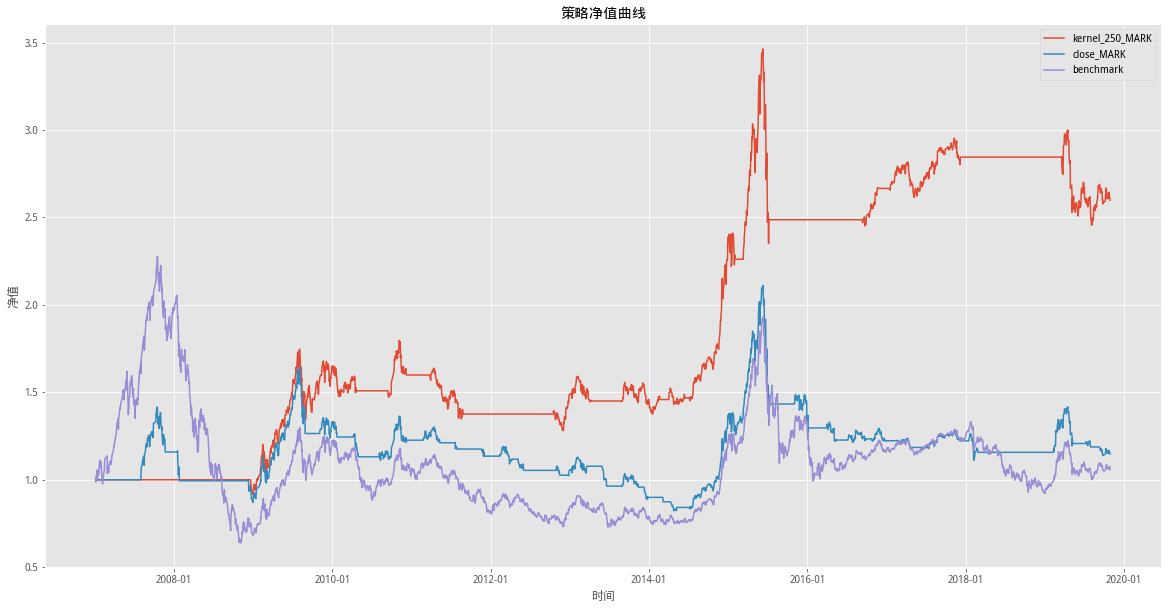

,kernel_250_MARK,close_MARK
年化收益率,7.91%,1.11%
累计收益率,159.85%,14.78%
夏普比率,0.50619,0.0790758
最大回撤,32.11%,50.07%
持仓总天数,1406,1419
交易次数,11,31
平均持仓天数,127.818,45.7742
获利天数,772,775
亏损天数,633,643
胜率(按天),54.91%,54.62%


In [15]:
singal_df = VT_Factor('000001.sh', '20070101', '20191031', 250).get_singal
BackTesting(singal_df, ['kernel_250', 'close'], method='MA').plot_net_value
BackTesting(singal_df, ['kernel_250', 'close'], method='MA').summary

在上证综指上来看，对牛熊指标使用双均线择时之后在指数上进行操作的择时收益率比较可观，年化收益8.24%，夏普比率 0.6，明显好于直接对指数进行择时，也明显好于指数表现。使用双均线系统对牛熊指标进行择时相比于对指数直接择时，胜率有明显的提高。特别是在 2011 年至 2013 年、2016 年至 2017 年这种震荡市，采用牛熊指标进行判断的优势很大。

### <font color=IndianRed>上证 50 双均线策略比较</font>

考察两种做法在上证50上的表现。对于指数的主要4个上升区间，采用牛熊指标择时对 09 年、15 年、17 年三次捕捉较好，对于07年的牛市，牛熊指标仅捕捉到了前半程。直接对指数进行择时则对 07 年、09 年两 次主要的上升区间把握较好，对于 15 年和 17 年则相对较弱。而在 2011 年至 2014 年的 震荡市，牛熊指标构造的择时策略净值维持在了较高水平，没有发生持续性的下跌，而直 接对指数择时在这段时间出现了持续性的下跌。从策略的绩效表现来看，采用牛熊指标进行择时胜率明显提升，交易次数明显下降，年化收益提升至8.96%，夏普比率也提升到了一个较为可观的水平。

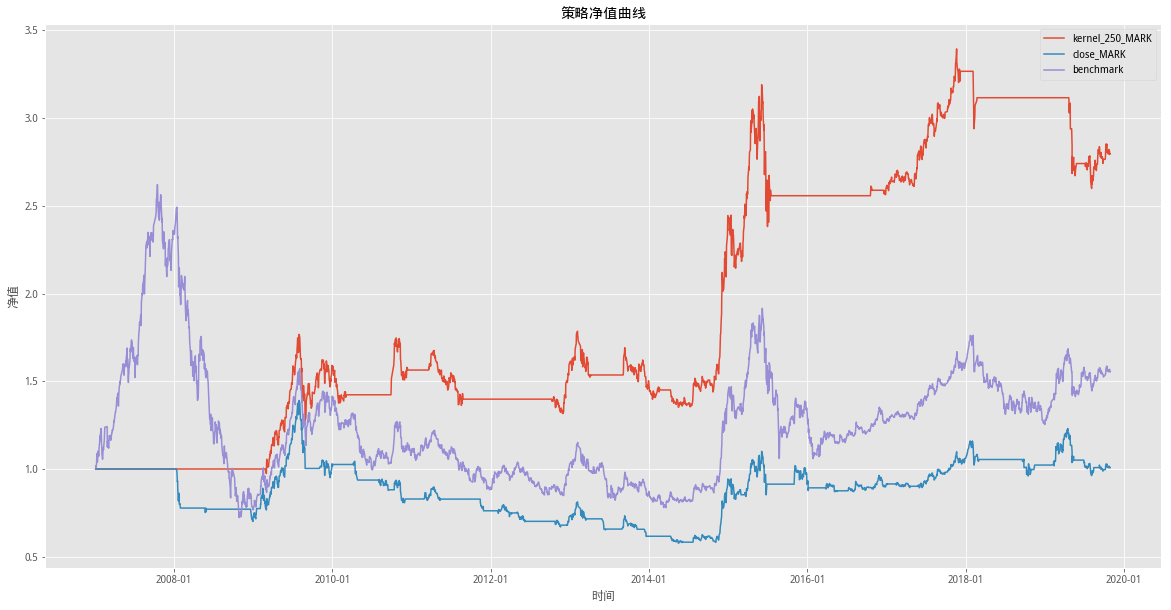

,kernel_250_MARK,close_MARK
年化收益率,8.54%,0.06%
累计收益率,179.54%,0.73%
夏普比率,0.474004,-0.0124298
最大回撤,27.88%,58.46%
持仓总天数,1304,1425
交易次数,12,33
平均持仓天数,108.667,43.1818
获利天数,677,729
亏损天数,626,695
胜率(按天),51.92%,51.16%


In [16]:
singal_df = VT_Factor('000016.sh', '20070101', '20191031', 250).get_singal
BackTesting(singal_df, ['kernel_250', 'close'], method='MA').plot_net_value
BackTesting(singal_df, ['kernel_250', 'close'], method='MA').summary

### <font color=IndianRed>沪深 300 双均线策略比较</font>

牛熊指标双均线择时策略在沪深 300指数上的表现与上证50类似，对于2007年的牛市， 仅捕捉到了前半程，但是对于后面的几次机会把握都比较好，在震荡市中的表现更为突出。 牛熊指标双均线策略的胜率与盈亏比都高于指数自身双均线择时策略。年化收益与夏普比
率上的表现都比较可观。

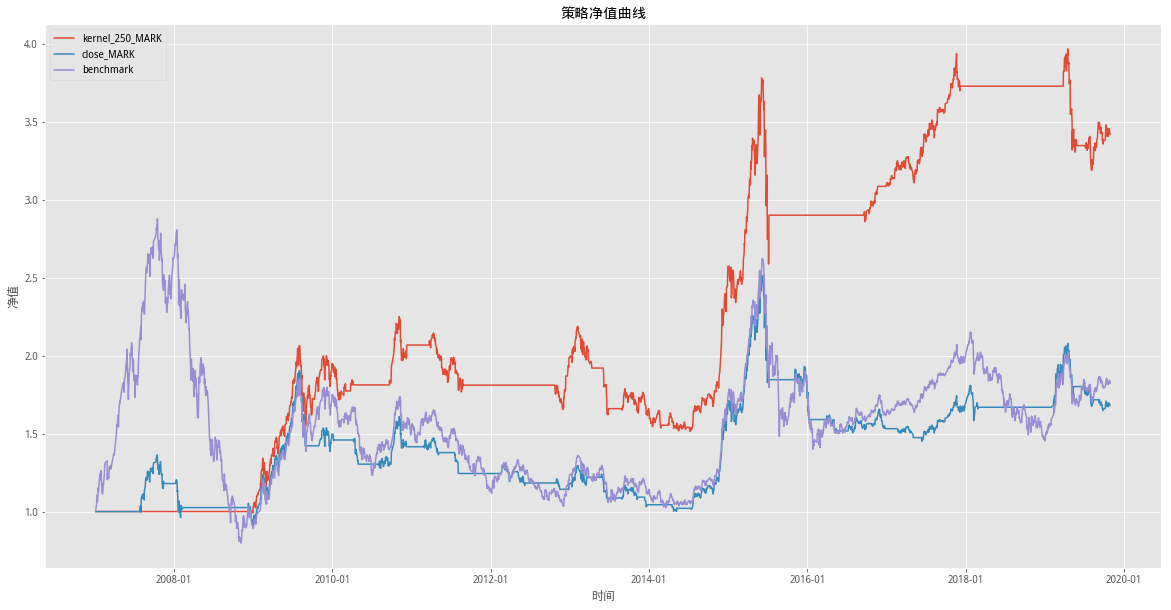

,kernel_250_MARK,close_MARK
年化收益率,10.31%,4.23%
累计收益率,242.37%,68.07%
夏普比率,0.595511,0.239654
最大回撤,32.72%,47.38%
持仓总天数,1388,1488
交易次数,16,26
平均持仓天数,86.75,57.2308
获利天数,755,800
亏损天数,632,687
胜率(按天),54.39%,53.76%


In [17]:
singal_df = VT_Factor('000300.sh', '20070101', '20191031', 250).get_singal
BackTesting(singal_df, ['kernel_250', 'close'], method='MA').plot_net_value
BackTesting(singal_df, ['kernel_250', 'close'], method='MA').summary

### <font color=IndianRed>中证 500 双均线策略比较</font>

在中证 500 指数上，牛熊指标双均线择时策略相比于自身择时策略而言明显更优，胜率和 盈亏比都有所提高，交易频率也大大下降。

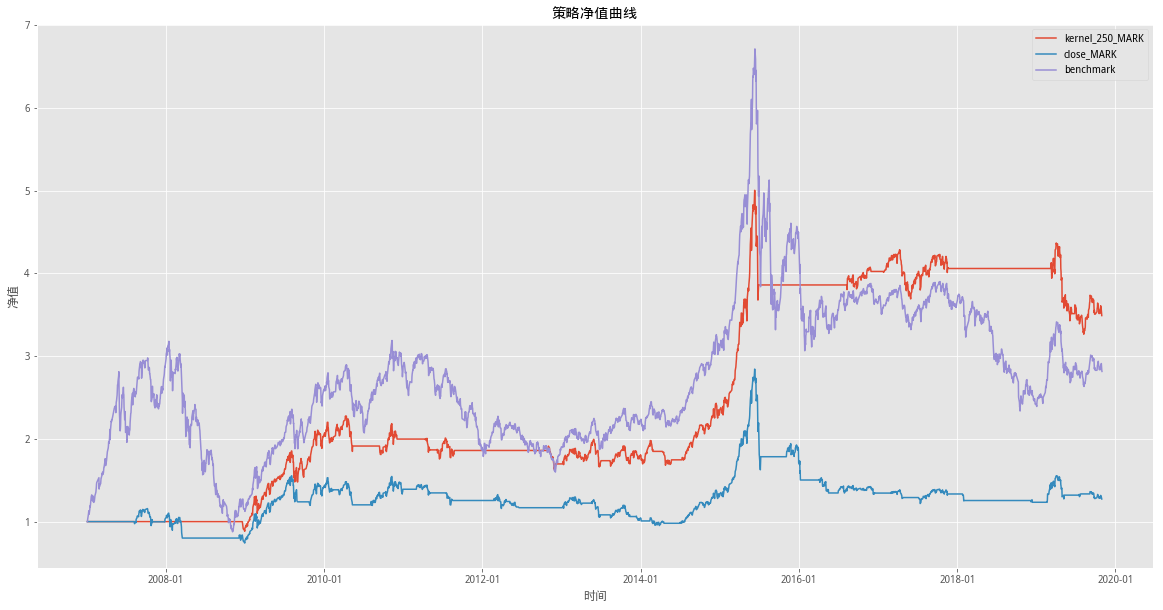

,kernel_250_MARK,close_MARK
年化收益率,10.48%,1.94%
累计收益率,249.01%,27.32%
夏普比率,0.617326,0.165373
最大回撤,34.76%,57.15%
持仓总天数,1420,1521
交易次数,14,30
平均持仓天数,101.429,50.7
获利天数,828,868
亏损天数,591,652
胜率(按天),58.31%,57.07%


In [18]:
singal_df = VT_Factor('000905.sh', '20070101', '20191031', 250).get_singal
BackTesting(singal_df, ['kernel_250', 'close'], method='MA').plot_net_value
BackTesting(singal_df, ['kernel_250', 'close'], method='MA').summary

## <font color=IndianRed>布林带策略对牛熊指标择时更为稳健</font>

与双均线策略类似，我们采用布林带策略对每个指数对应的牛熊指标和其自身分别进行择时，对比两者的择时效果。布林带是技术指标择时中另一类策略的代表，是通道类策略中的经典策略。采用布林带策略对牛熊指标进行择时和指数本身择时，在**收益率上差异不大**， 甚至在**部分指数上直接对指数进行择时的收益要好于对牛熊指标进行择时**，但是从净值的走势来看，采用牛熊指标进行择时稳健性更好，其交易次数更低，在市场行情不好时，策略选择空仓，而不是频繁交易使净值出现下跌。对于投资者来说是一个更容易接受的策略。

### <font color=IndianRed>上证综指布林带策略比较</font>

以上证综指为标的的两种择时策略收益端直接使用原指标更好总体相差2%，净值走势也较为一致，只是直接 对指数本身择时的策略交易次数更多，完全空仓的时间更短，净值的平稳性稍稍弱于对牛熊指标择时的策略。

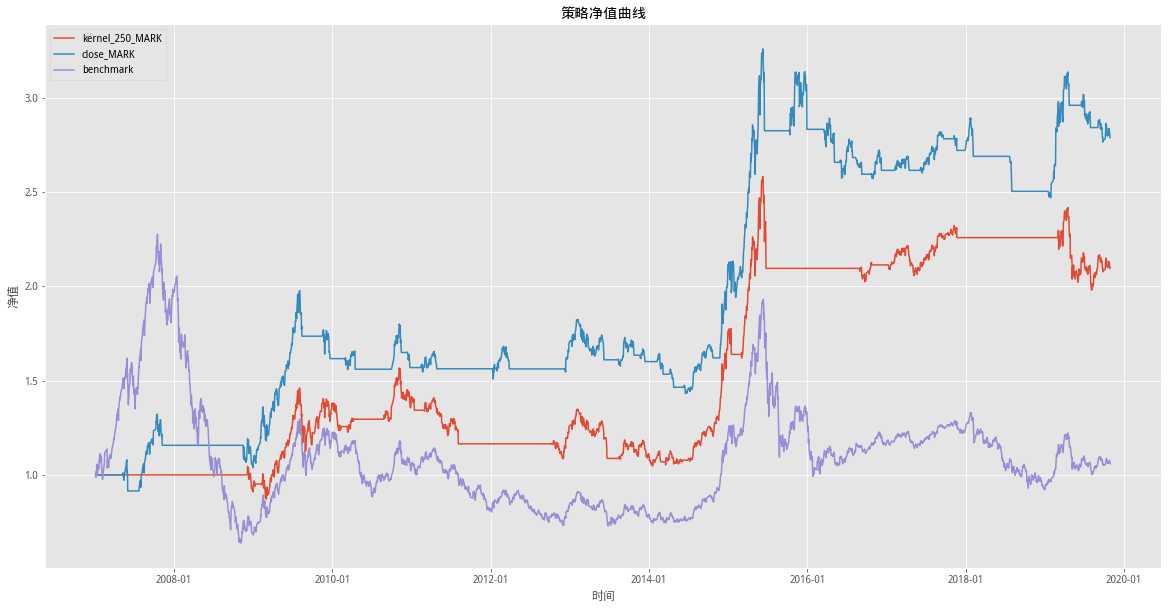

,kernel_250_MARK,close_MARK
年化收益率,6.08%,8.53%
累计收益率,109.55%,178.99%
夏普比率,0.395968,0.607453
最大回撤,33.23%,27.61%
持仓总天数,1464,1402
交易次数,13,29
平均持仓天数,112.615,48.3448
获利天数,805,777
亏损天数,658,624
胜率(按天),54.99%,55.42%


In [19]:
singal_df = VT_Factor('000001.sh', '20070101', '20191031', 250).get_singal
BackTesting(singal_df, ['kernel_250', 'close'], method='BBANDS').plot_net_value
BackTesting(singal_df, ['kernel_250', 'close'], method='BBANDS').summary

### <font color=IndianRed>上证 50布林带策略比较</font>

考察上证 50 指数上布林带两种策略的应用，直接对指数本身择时虽然收益率较高，但是其收益主要来源于 2009 年以前，之后接近六年的时间一直在回撤，这种策略在实际应用 中是较难使用的，投资者需要忍受漫长的回撤期。对牛熊指标择时的策略虽然前几年收益 没有特别高，但是整体表现更平稳，09 年以后表现明显好于直接对指数择时的策略，而且胜率也更高。

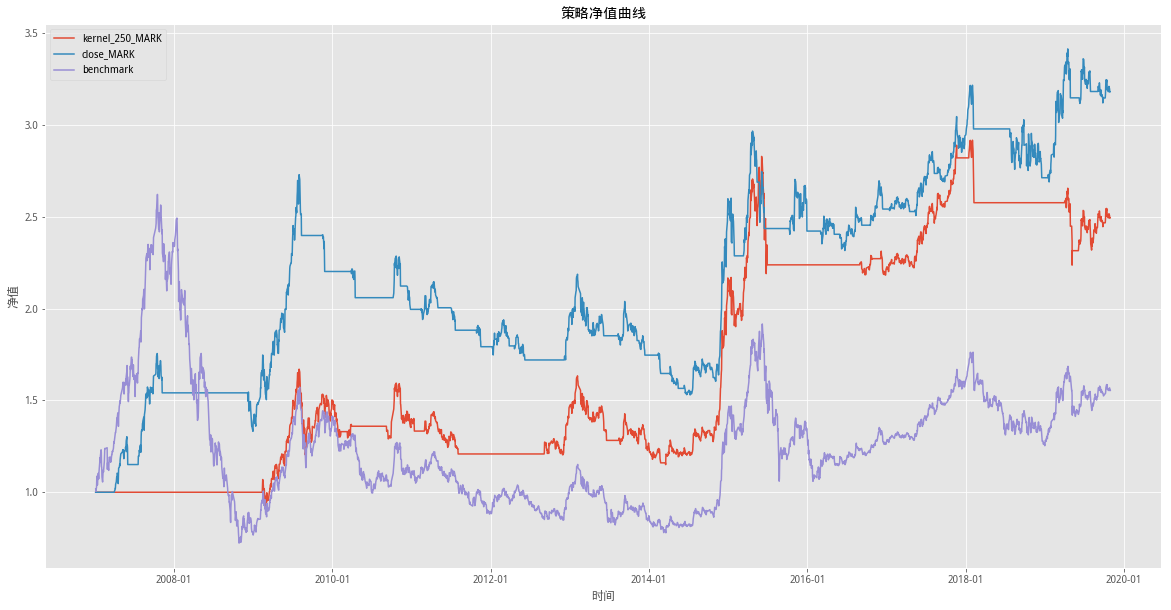

,kernel_250_MARK,close_MARK
年化收益率,7.56%,9.67%
累计收益率,149.34%,218.03%
夏普比率,0.411791,0.614985
最大回撤,31.11%,43.94%
持仓总天数,1488,1645
交易次数,12,32
平均持仓天数,124,51.4062
获利天数,767,850
亏损天数,720,794
胜率(按天),51.55%,51.67%


In [20]:
singal_df = VT_Factor('000016.sh', '20070101', '20191031', 250).get_singal
BackTesting(singal_df, ['kernel_250', 'close'], method='BBANDS').plot_net_value
BackTesting(singal_df, ['kernel_250', 'close'], method='BBANDS').summary

### <font color=IndianRed>沪深 300 布林带策略比较</font>

应用到沪深 300 上，对牛熊指标择时的策略收益要弱于直接对指数择时的策略。主要原因是 2007 年的牛市对牛熊指标择时的策略没有能够把握住。2007 年之后，实际上还是对牛熊指标择时的策略表现更为稳健(<font color=LightCoral>强行找理由</font>)。

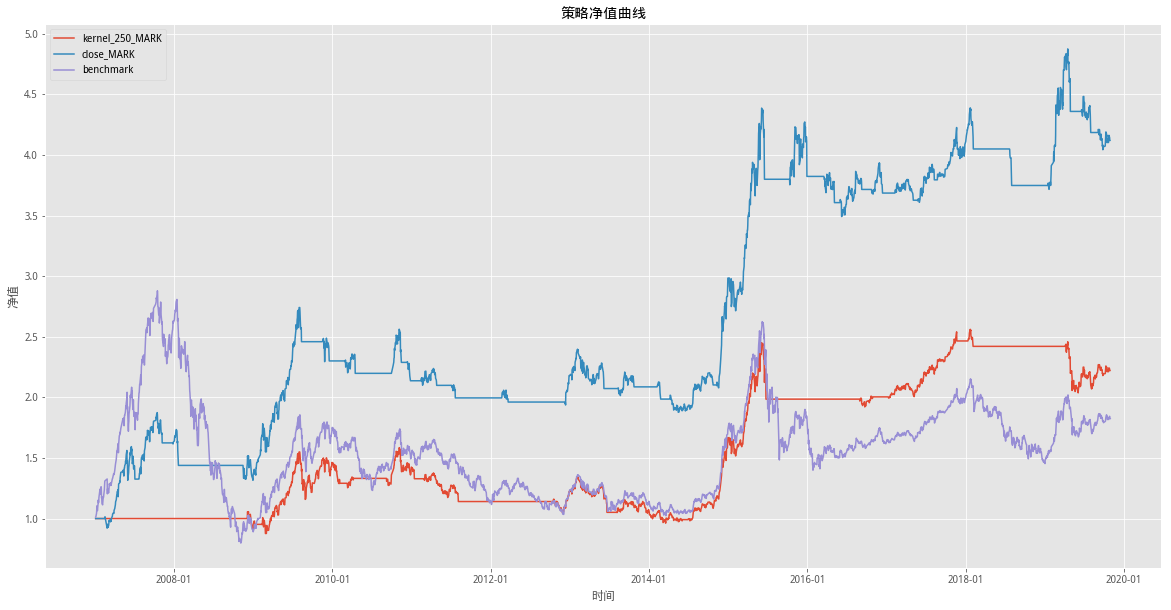

,kernel_250_MARK,close_MARK
年化收益率,6.57%,11.95%
累计收益率,122.12%,312.03%
夏普比率,0.384112,0.726542
最大回撤,39.31%,31.52%
持仓总天数,1494,1569
交易次数,13,27
平均持仓天数,114.923,58.1111
获利天数,802,865
亏损天数,691,703
胜率(按天),53.68%,55.13%


In [21]:
singal_df = VT_Factor('000300.sh', '20070101', '20191031', 250).get_singal
BackTesting(singal_df, ['kernel_250', 'close'], method='BBANDS').plot_net_value
BackTesting(singal_df, ['kernel_250', 'close'], method='BBANDS').summary

# <font color=IndianRed>中证 500 布林带策略比较</font>

中证 500 上采用布林带对牛熊指标择时和直接对指数择时的效果差异不是很大，主要的机 会都有所把握，但是准确率上还是牛熊指标择时效果更好一点，所以择时收益率更高。

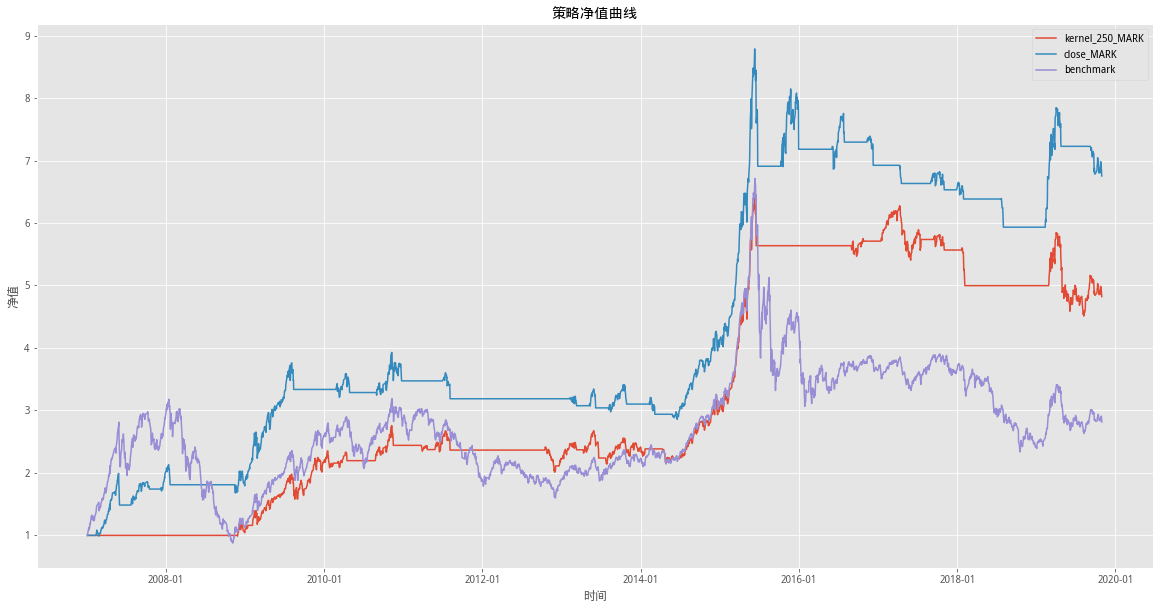

,kernel_250_MARK,close_MARK
年化收益率,13.37%,16.45%
累计收益率,382.19%,575.25%
夏普比率,0.778645,0.92956
最大回撤,30.78%,32.48%
持仓总天数,1326,1139
交易次数,17,21
平均持仓天数,78,54.2381
获利天数,779,689
亏损天数,546,449
胜率(按天),58.75%,60.49%


In [22]:
singal_df = VT_Factor('000905.sh', '20070101', '20191031', 250).get_singal
BackTesting(singal_df, ['kernel_250', 'close'], method='BBANDS').plot_net_value
BackTesting(singal_df, ['kernel_250', 'close'], method='BBANDS').summary

# <font color=IndianRed>信号及敏感性分析</font>

##  <font color=IndianRed>分析上证综指信号分布</font>

In [23]:
# 初始化
vt = VT_Factor('000001.sh', '20070101', '20191031', 250)

# 获取数据df
singal_df = vt.get_singal

In [24]:
# 查看数据结构
singal_df.head()

,close,pct_chg,turnover_rate_f,kernel_250
trade_date,,,,
2007-01-04,2715.719,1.5042,NaN,NaN
2007-01-05,2641.334,-2.7391,5.45,NaN
2007-01-08,2707.199,2.4936,5.47,NaN
2007-01-09,2807.804,3.7162,5.51,NaN
2007-01-10,2825.576,0.6330,5.69,NaN


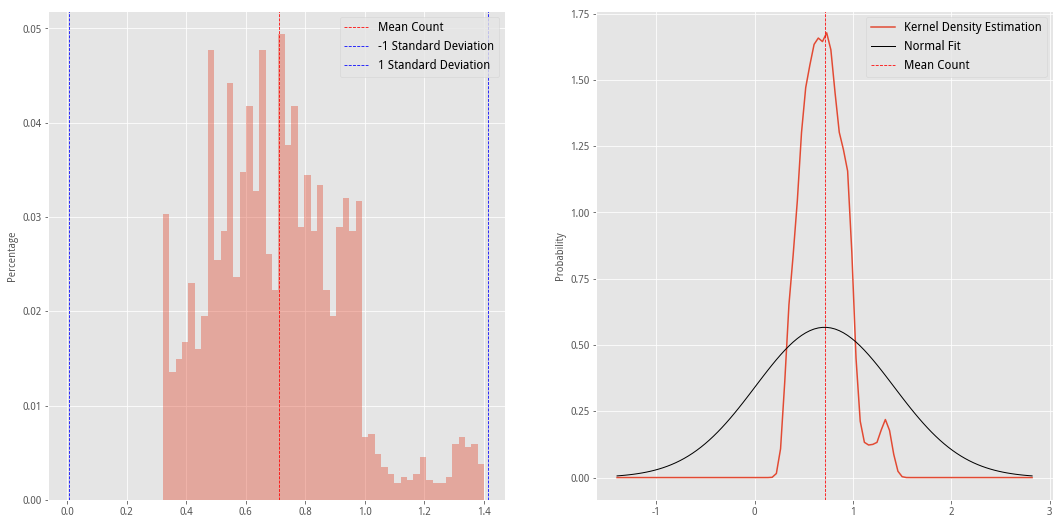


        平均数 : 0.7111
        中位数 : 0.7038
        标准差 : 0.2234
        偏度   : 0.5968
        峰度   : 0.3421
        1 Standard Deviation : 0.9345
        -1 Standard Deviation : 0.4877
        Min:0.3211
        Max:1.4011
        


In [25]:
# 查看信号 分布
Data_Distribution_Plot(singal_df, 'kernel_250')
Statistical_indicator(singal_df, 'kernel_250')

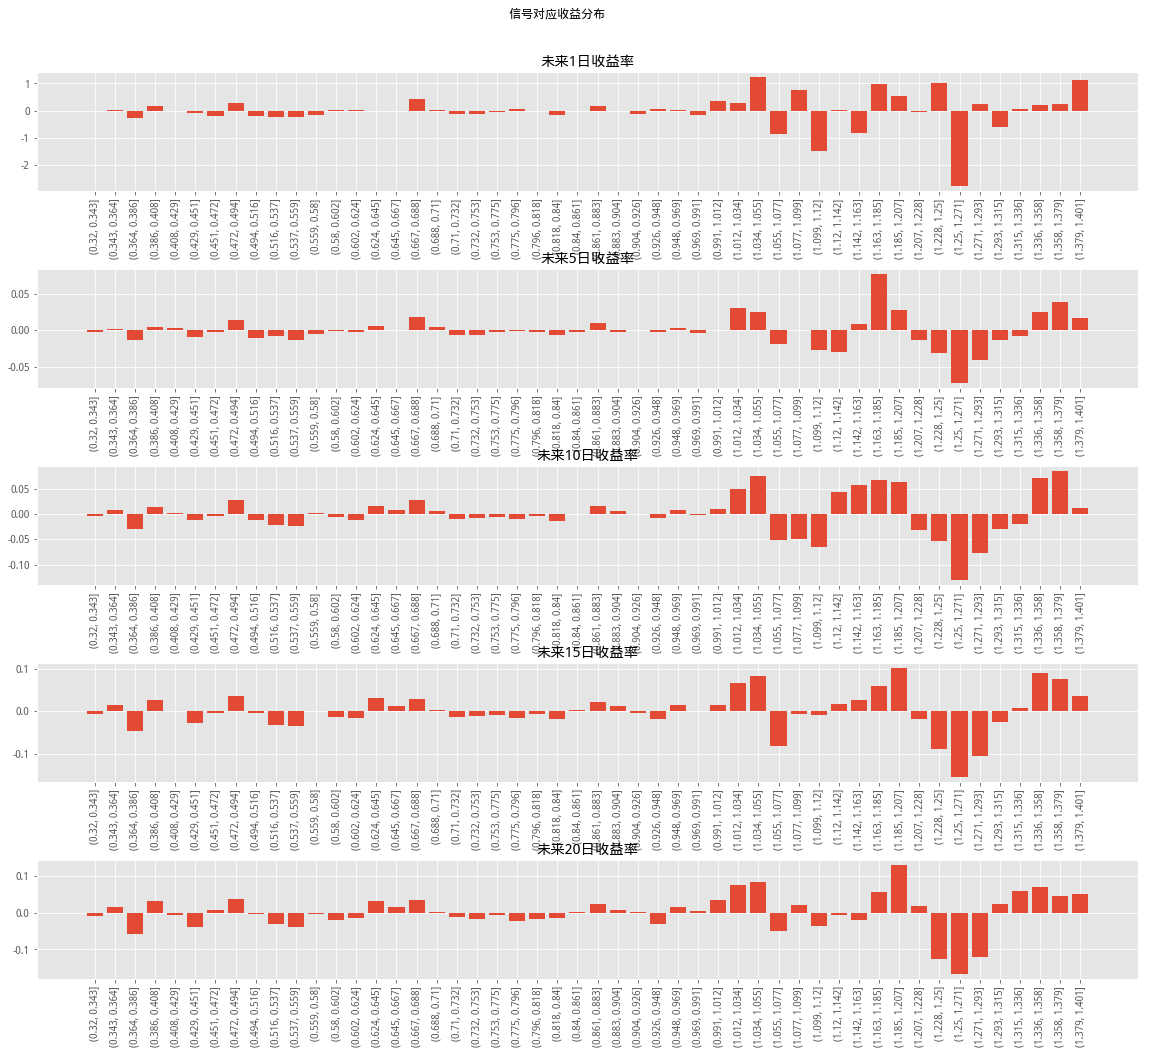

In [26]:
# 查看数据分布对应的未来收益
vt.forward_distribution_plot(250, bins=50)

可以看到信号在min~-1SD,1SD~max之间对应的5~20为未来收益显著大于0

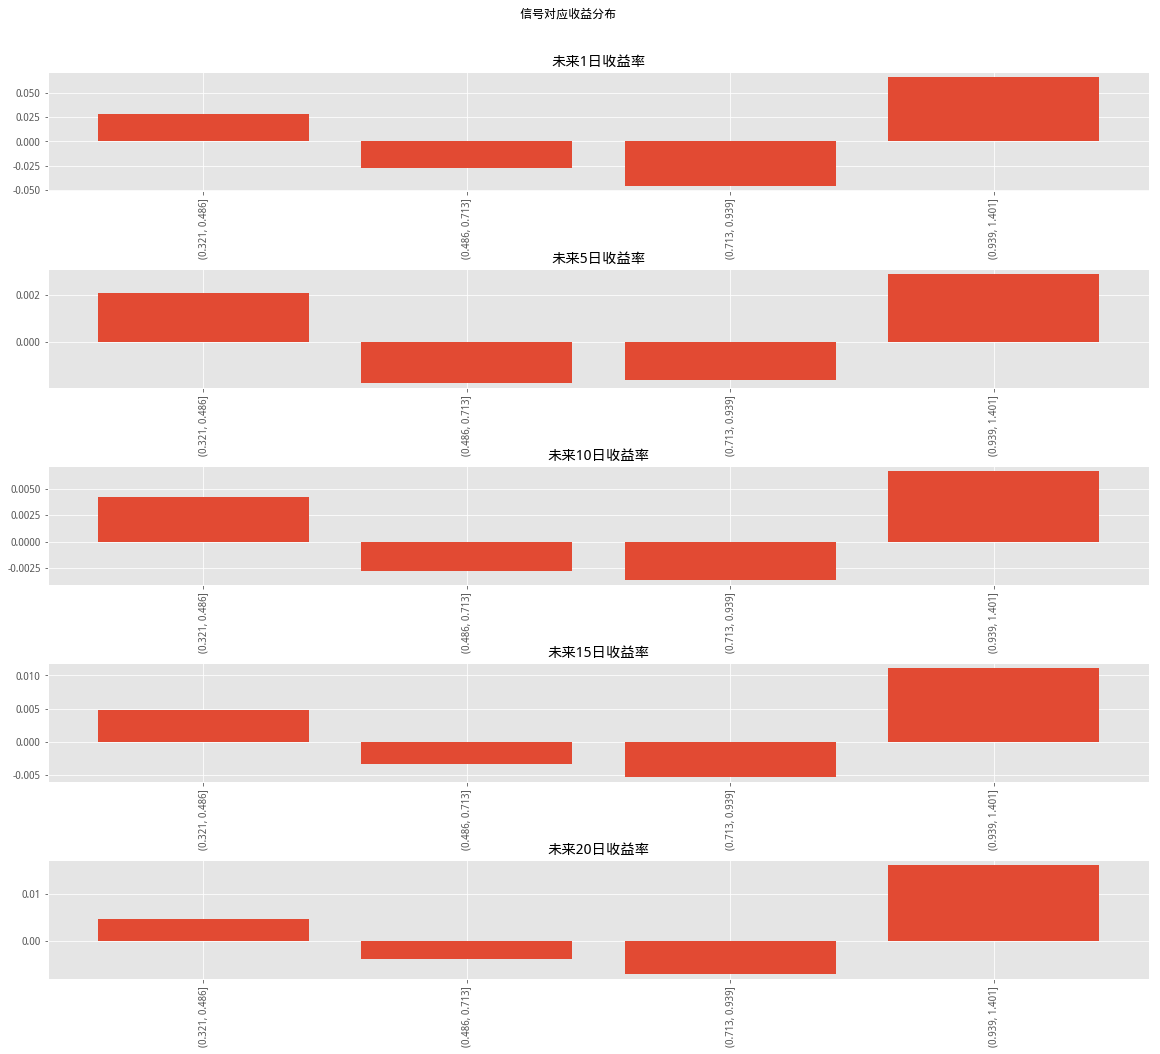

In [27]:
# 信号分布在min~-1SD,-1SD~mean,mean~1SD,1SD~max 对应的未来收益情况
vt.forward_distribution_plot(
    250, bins=[0.3211, 0.4863, 0.7126, 0.9389, 1.4011])

信号值大小对应未来收益率的变化如图

                         QuantReg Regression Results                          
Dep. Variable:             kernel_250   Pseudo R-squared:            2.242e-05
Model:                       QuantReg   Bandwidth:                     0.07726
Method:                 Least Squares   Sparsity:                       0.6193
Date:                Wed, 06 Nov 2019   No. Observations:                 2858
Time:                        23:27:45   Df Residuals:                     2856
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7009      0.006    121.012      0.000       0.690       0.712
未来15日收益率       0.0811      0.091      0.890      0.374      -0.098       0.260


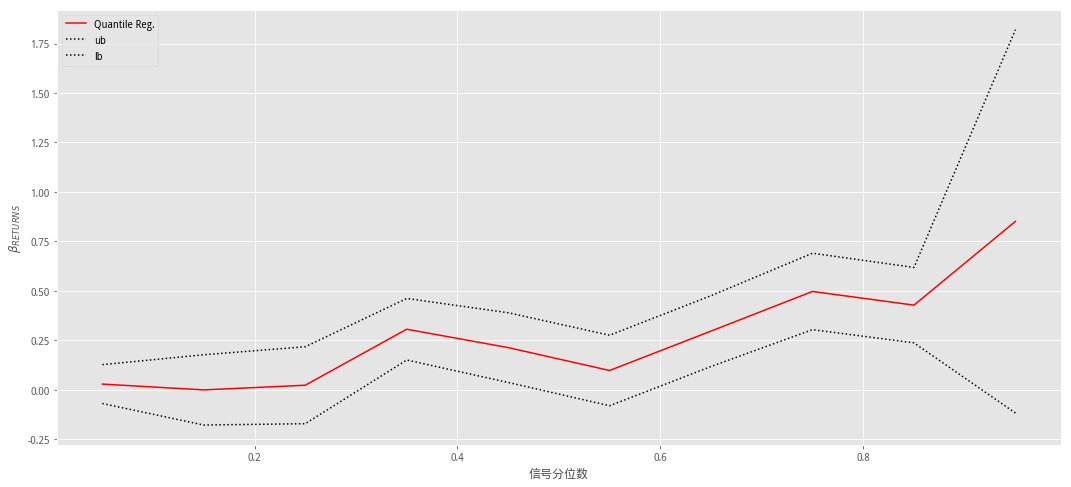

In [28]:
# 分位数回归
vt.QuantReg_plot(forward_ret_name='未来15日收益率', singal_periods=250)

## <font color=IndianRed>敏感性分析</font>

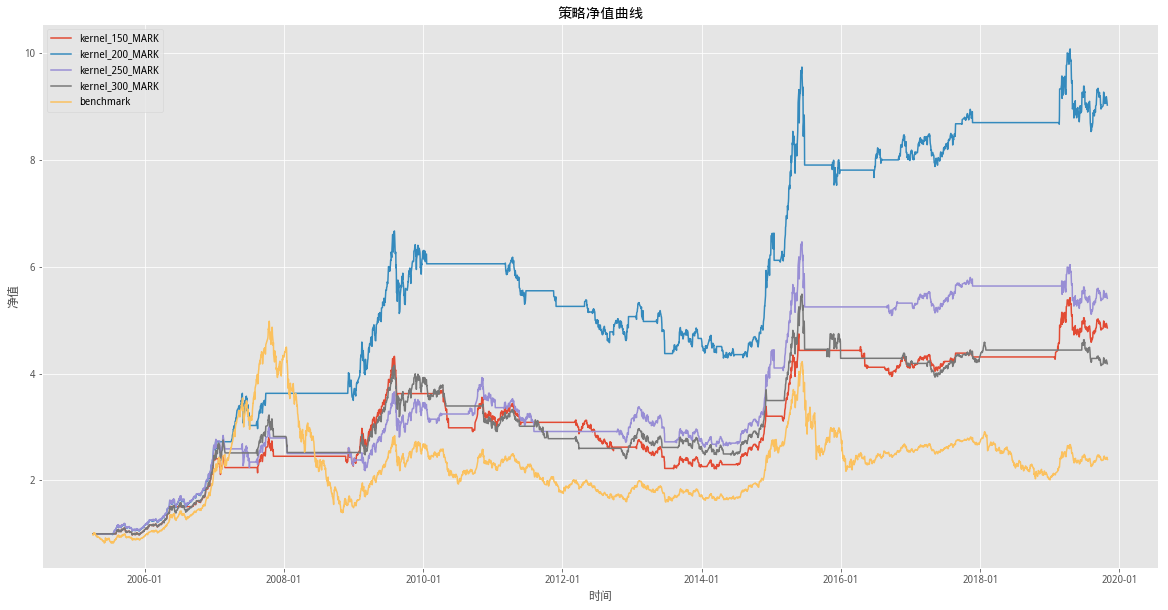

,kernel_150_MARK,kernel_200_MARK,kernel_250_MARK,kernel_300_MARK
年化收益率,11.73%,16.70%,12.58%,10.57%
累计收益率,385.27%,802.28%,440.67%,318.21%
夏普比率,0.811422,1.02654,0.791263,0.711084
最大回撤,48.74%,35.68%,33.23%,42.06%
持仓总天数,1749,1862,1920,1814
交易次数,18,22,18,17
平均持仓天数,97.1667,84.6364,106.667,106.706
获利天数,970,1070,1092,1025
亏损天数,778,791,827,788
胜率(按天),55.46%,57.47%,56.88%,56.50%


In [29]:
periods = [150, 200, 250,300]
singal_name = ['kernel_'+str(x) for x in periods]
singal_df = VT_Factor('000001.sh', '20040101', '20191031', periods).get_singal


# 参数不同前序所需数据不同将所有参数调整至同一起跑线
filter_nan = singal_df['kernel_'+str(max(periods))].isna().sum()
slice_df = singal_df.iloc[filter_nan:]

BackTesting(slice_df, singal_name, method='BBANDS').plot_net_value
BackTesting(slice_df, singal_name, method='BBANDS').summary